# Experimentación - DCRNN

https://arxiv.org/abs/1707.01926

## 1. Obtención de datos



In [2]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [29]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"
name_model = "AGCRN"
results_save_path = "./results"

In [4]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [5]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch


from utils.utils_graph import format_plot, plot_training_and_eval_losses, plot_predictions

from utils.trainer import TrainerDCRNN
from utils.models import DCRNNModel
dtype = torch.float
device = torch.device("cpu")

## Prueba - predicción por tipos

In [14]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}


num_early_stop = 0
num_epochs = 50
lr = 0.01

In [26]:
import itertools


def entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem=""):
    """
    Entrena y evalúa modelos con diferentes combinaciones de hiperparámetros, y devuelve el mejor modelo,
    los mejores parámetros y un DataFrame con los resultados.

    Args:
        param_grid (dict): Diccionario con listas de valores de los hiperparámetros a probar.
        n_features (int): Número de características del nodo.
        n_nodes (int): Número de nodos.
        n_target (int): Número de objetivos.
        dataloader (object): Objeto que proporciona los datos para entrenamiento y evaluación.
        num_early_stop (int): Número de épocas para detenerse tempranamente si no hay mejora.
        num_epochs (int): Número de épocas para entrenar.
        lr (float): Tasa de aprendizaje.

    Returns:
        mejor_modelo (object): El mejor modelo entrenado.
        mejores_parametros (tuple): Los mejores parámetros (aggr, conv, lstm).
        resultados_gt (pd.DataFrame): DataFrame con los resultados de todas las combinaciones de hiperparámetros.
    """
    resultados_list = []

    #Vamos a guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None

    n_nodes =dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[1]
    n_features = dataset[0].x.shape[1]


    device =torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    for hidden_size in tqdm(list(param_grid["hidden_size"])):
        

        model = DCRNNModel(name="DCRNN", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_dim=hidden_size)
        device =  torch.device("cpu")

        model.to(device)
        trainer = TrainerDCRNN(model, dataset,device, f"./results/{problem_gt}", dataloader_params2)


        losses,eval_losses, r2scores  = trainer.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        r2score_tst,losses_tst, loss_nodes, _, _ = trainer.test()

        results_intermedio = {
            "Embedding": hidden_size,
            "Loss_final": losses[-1],
            "R2_eval": np.mean(r2scores[-1]),
            "Loss_eval": np.mean(eval_losses[-1]),
            "R2_tst": np.mean(r2score_tst),
            "Loss_tst": np.mean(losses_tst),
            "Loss_nodes": np.mean(loss_nodes, axis=0).tolist()
        }
        # Añade los resultados a la lista
        resultados_list.append(results_intermedio)

        if np.mean(losses_tst) < mejor_loss_test:
            mejor_loss_test = np.mean(losses_tst)
            mejor_trainer = trainer
            mejores_parametros = {'hidden': hidden_size}
            mejores_resultados = results_intermedio

        print("Parámetros: ", hidden_size)
        print("Resultados: ", resultados_list[-1])

    resultados = pd.DataFrame(resultados_list)

    return mejor_trainer, mejores_parametros, mejores_resultados, resultados


### Gen trip

In [15]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [16]:

n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
hidden_size =32

#### Sencilla 

In [17]:
model_gt = DCRNNModel(name="DCRNN", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_dim=hidden_size)
device =  torch.device("cpu")

model_gt.to(device)
trainer_gt = TrainerDCRNN(model_gt, dataset_gt,device, f"./results/{problem_gt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_gt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.5887 | Eval Loss: 0.2546 | Eval R2: -109.3517 | LR: 0.0010 | 
Epoch 2/50 | Train Loss: 0.1560 | Eval Loss: 0.0920 | Eval R2: -28.4283 | LR: 0.0010 | 
Epoch 3/50 | Train Loss: 0.0810 | Eval Loss: 0.0673 | Eval R2: -17.4625 | LR: 0.0010 | 
Epoch 4/50 | Train Loss: 0.0692 | Eval Loss: 0.0609 | Eval R2: -15.6218 | LR: 0.0010 | 
Epoch 5/50 | Train Loss: 0.0623 | Eval Loss: 0.0540 | Eval R2: -13.8099 | LR: 0.0010 | 
Epoch 6/50 | Train Loss: 0.0542 | Eval Loss: 0.0456 | Eval R2: -11.6639 | LR: 0.0010 | 
Epoch 7/50 | Train Loss: 0.0449 | Eval Loss: 0.0376 | Eval R2: -10.0473 | LR: 0.0010 | 
Epoch 8/50 | Train Loss: 0.0369 | Eval Loss: 0.0315 | Eval R2: -8.9087 | LR: 0.0010 | 
Epoch 9/50 | Train Loss: 0.0305 | Eval Loss: 0.0266 | Eval R2: -7.8492 | LR: 0.0010 | 
Epoch 10/50 | Train Loss: 0.0256 | Ev

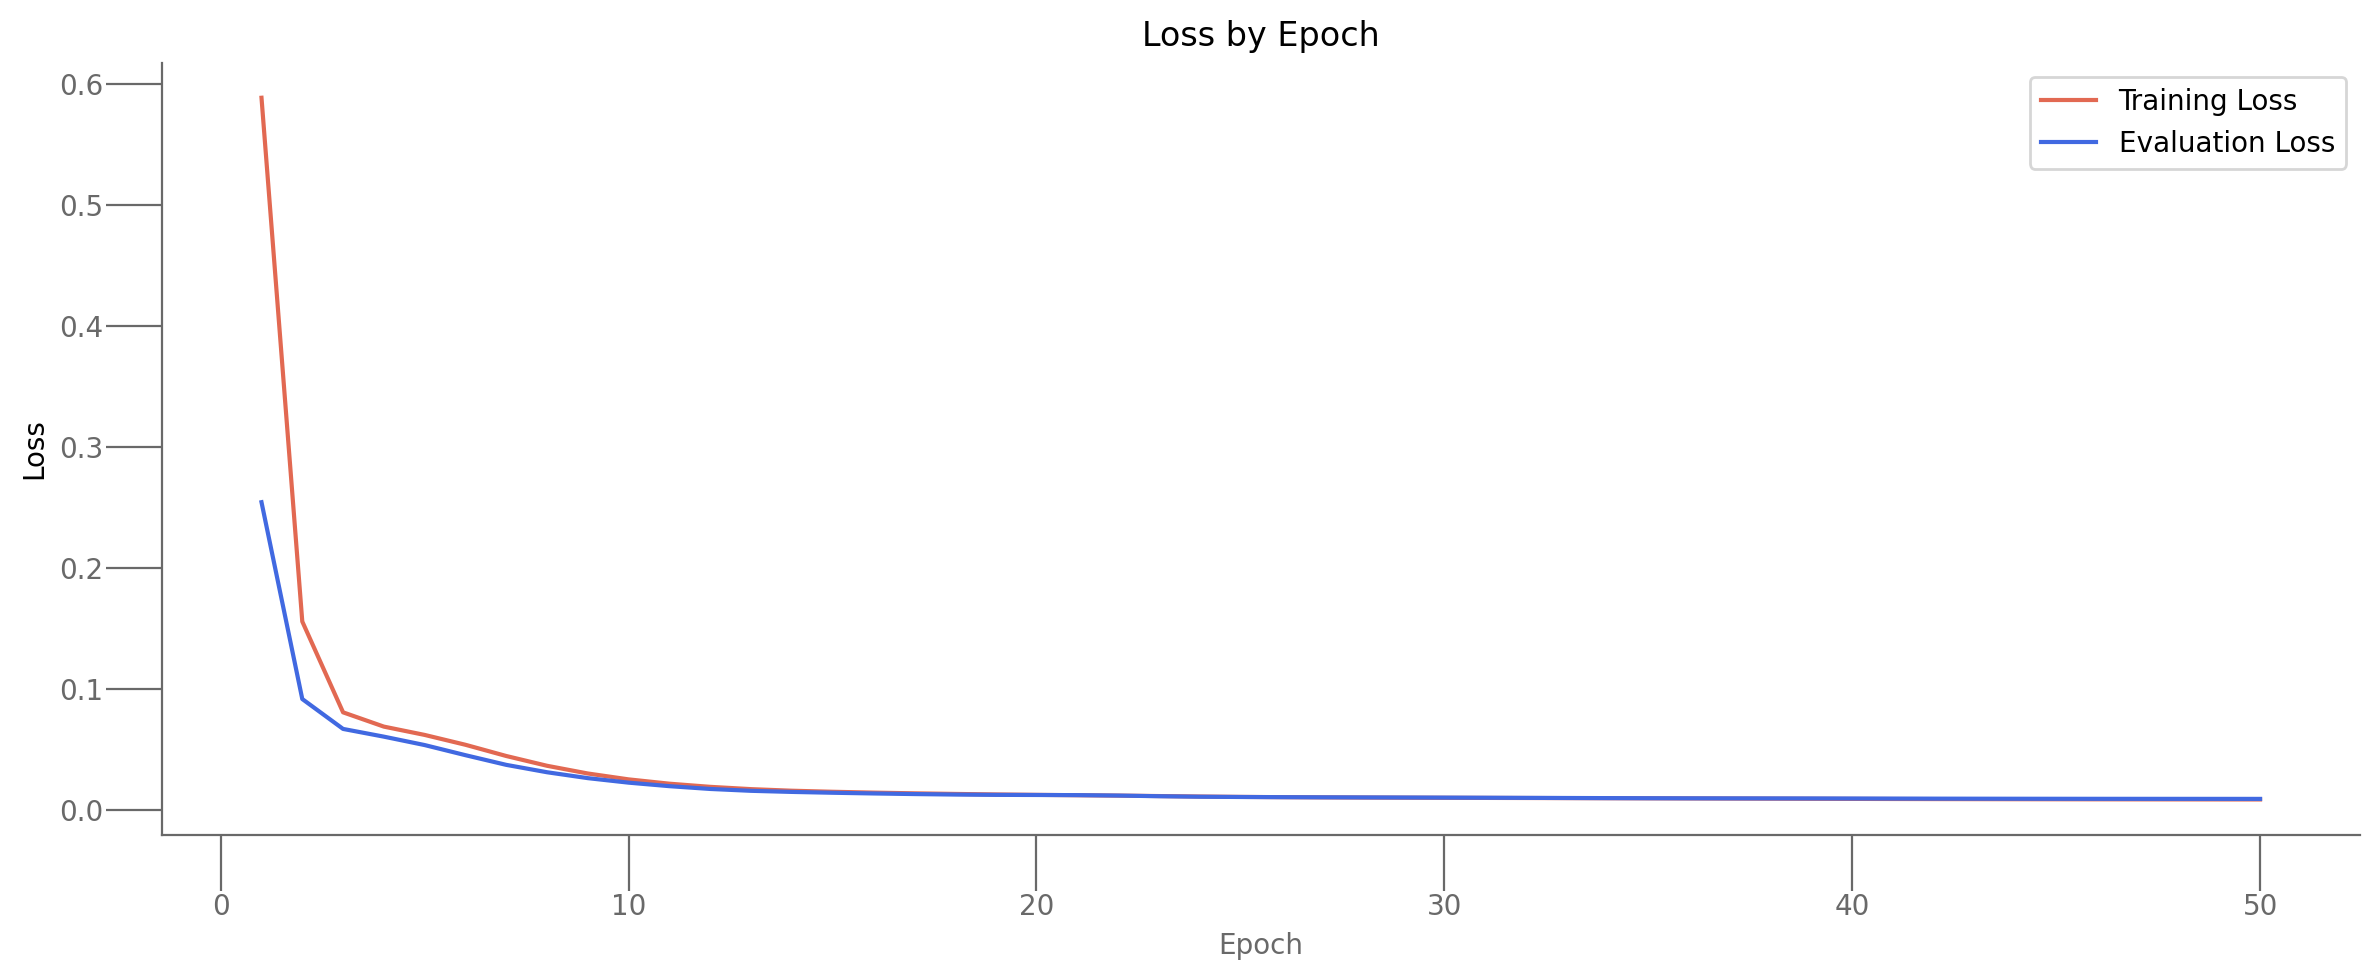


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.006968, test R2 score: -1.603802


In [18]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_gt, real_gt = trainer_gt.test()



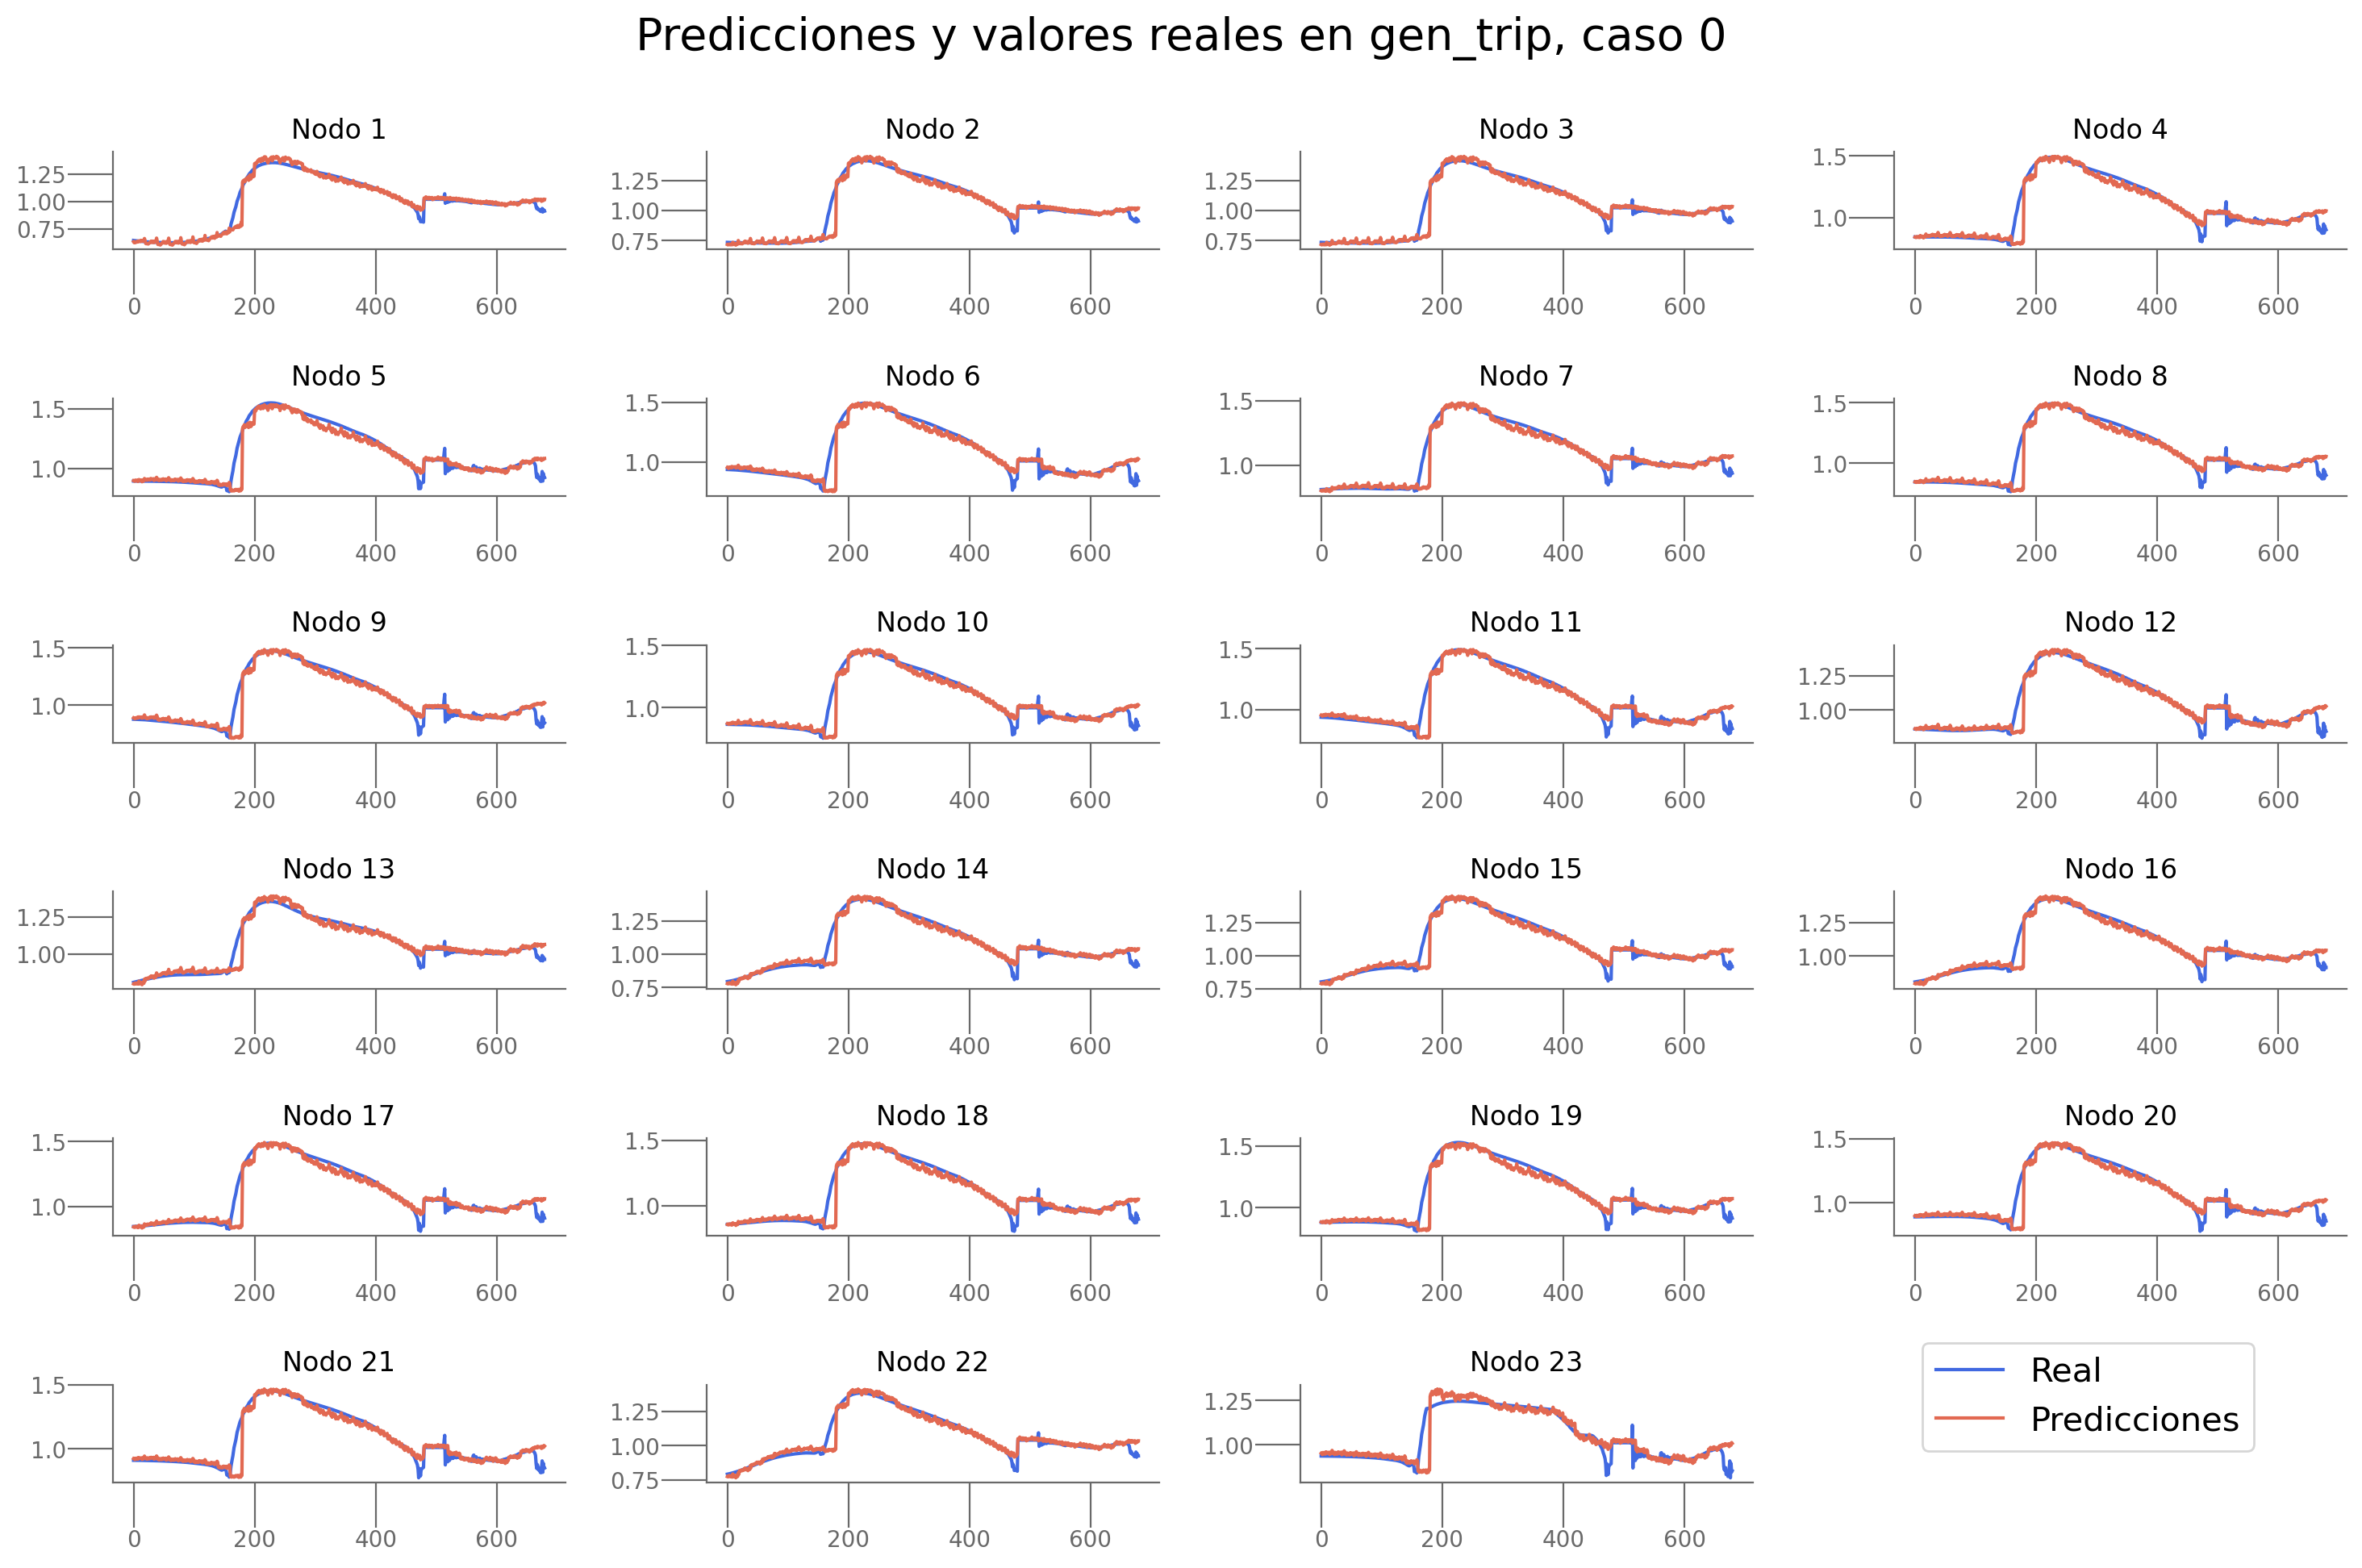

In [19]:
plot_predictions(predictions_gt, real_gt, n_target, 0, n_div_gt, problem_gt)

#### Ajuste de parámetros 

In [27]:
param_grid = {
    "hidden_size": [10,20,40,60]
}

trainer_gt,params_gt, resultados_final_gt, resultados_gt = entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset_gt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_gt)

  0%|          | 0/4 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.5080 | Eval Loss: 0.2118 | Eval R2: -89.5111 | LR: 0.0010 | 
Epoch 2/50 | Train Loss: 0.1221 | Eval Loss: 0.0696 | Eval R2: -21.4536 | LR: 0.0010 | 
Epoch 3/50 | Train Loss: 0.0536 | Eval Loss: 0.0391 | Eval R2: -10.2027 | LR: 0.0010 | 
Epoch 4/50 | Train Loss: 0.0346 | Eval Loss: 0.0278 | Eval R2: -6.8484 | LR: 0.0010 | 
Epoch 5/50 | Train Loss: 0.0254 | Eval Loss: 0.0211 | Eval R2: -5.3273 | LR: 0.0010 | 
Epoch 6/50 | Train Loss: 0.0202 | Eval Loss: 0.0174 | Eval R2: -4.3231 | LR: 0.0010 | 
Epoch 7/50 | Train Loss: 0.0171 | Eval Loss: 0.0152 | Eval R2: -3.5596 | LR: 0.0010 | 
Epoch 8/50 | Train Loss: 0.0153 | Eval Loss: 0.0138 | Eval R2: -3.2294 | LR: 0.0010 | 
Epoch 9/50 | Train Loss: 0.0141 | Eval Loss: 0.0129 | Eval R2: -2.9954 | LR: 0.0010 | 
Epoch 10/50 | Train Loss: 0.0131 | Eval Lo

 25%|██▌       | 1/4 [03:13<09:41, 193.73s/it]

preds:  (1, 23, 20)
test loss: 0.006898, test R2 score: -1.667993
Parámetros:  10
Resultados:  {'Embedding': 10, 'Loss_final': 0.008212880231440067, 'R2_eval': -1.549892783164978, 'Loss_eval': 0.009214475750923157, 'R2_tst': -1.6679925084686857, 'Loss_tst': 0.0068975938484072685, 'Loss_nodes': [[0.0019146326230838895, 0.003743845270946622, 0.004706668201833963, 0.0026437060441821814, 0.008069977164268494, 0.004081367049366236, 0.0037524935323745012, 0.004897300153970718, 0.004979592747986317, 0.005073912441730499, 0.00508471205830574, 0.007164624985307455, 0.008102607913315296, 0.00925816036760807, 0.009180639870464802, 0.008533480577170849, 0.013070184737443924, 0.010816185735166073, 0.00970594771206379, 0.013171817176043987]]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.5593 | Eval Loss: 0.2592 | Eval R2: -109.0540 | LR: 0.0010 | 


 50%|█████     | 2/4 [06:09<06:05, 182.91s/it]

preds:  (1, 23, 20)
test loss: 0.006949, test R2 score: -1.704541
Parámetros:  20
Resultados:  {'Embedding': 20, 'Loss_final': 0.008757339790463448, 'R2_eval': -1.5932894945144653, 'Loss_eval': 0.009400608949363232, 'R2_tst': -1.7045405447495123, 'Loss_tst': 0.006948938127607107, 'Loss_nodes': [[0.0019030554685741663, 0.0037804157473146915, 0.004950054455548525, 0.0027625656221061945, 0.008122761733829975, 0.004378148820251226, 0.004022564738988876, 0.004906365182250738, 0.005138958804309368, 0.005306298844516277, 0.004688198212534189, 0.00700546707957983, 0.007750365417450666, 0.009042588993906975, 0.009215004742145538, 0.00859312154352665, 0.012939322739839554, 0.011259231716394424, 0.009869342669844627, 0.01334493700414896]]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.2920 | Eval Loss: 0.0663 | Eval R2: -17.6924 | LR: 0.0010 | 
E

 75%|███████▌  | 3/4 [09:21<03:07, 187.31s/it]

preds:  (1, 23, 20)
test loss: 0.007293, test R2 score: -2.041025
Parámetros:  40
Resultados:  {'Embedding': 40, 'Loss_final': 0.008074481971561909, 'R2_eval': -1.850043535232544, 'Loss_eval': 0.00971291121095419, 'R2_tst': -2.0410251034885287, 'Loss_tst': 0.007293247152119875, 'Loss_nodes': [[0.0019607986323535442, 0.004174965899437666, 0.00442353542894125, 0.0030487687326967716, 0.008212033659219742, 0.004178029019385576, 0.004197810310870409, 0.005397274624556303, 0.0050544096156954765, 0.005991864018142223, 0.0050220494158566, 0.007775100879371166, 0.008818337693810463, 0.009803215973079205, 0.010191471315920353, 0.008673734031617641, 0.013613030314445496, 0.011085201054811478, 0.010023250244557858, 0.014220076613128185]]}

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.1814 | Eval Loss: 0.0502 | Eval R2: -13.0396 | LR: 0.0010 | 
Epo

100%|██████████| 4/4 [12:39<00:00, 189.81s/it]

preds:  (1, 23, 20)
test loss: 0.007810, test R2 score: -2.422457
Parámetros:  60
Resultados:  {'Embedding': 60, 'Loss_final': 0.007629462517797947, 'R2_eval': -2.142382860183716, 'Loss_eval': 0.010261769406497478, 'R2_tst': -2.4224573849014015, 'Loss_tst': 0.007809814997017384, 'Loss_nodes': [[0.002941273618489504, 0.005372240208089352, 0.0046060713939368725, 0.0036138384602963924, 0.008341196924448013, 0.004342778120189905, 0.004445801489055157, 0.005747990682721138, 0.005426608491688967, 0.006142802536487579, 0.005518537480384111, 0.008353780955076218, 0.0088457390666008, 0.010164076462388039, 0.009773604571819305, 0.009408976882696152, 0.0156411062926054, 0.01167726144194603, 0.010666940361261368, 0.015165641903877258]]}


In [30]:
path_save_experiment_gt = results_save_path+f"/{problem_gt}"+ f"/ajustes/{name_model}_results.csv"
resultados_gt.to_csv(path_save_experiment_gt, index=False)


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.006898, test R2 score: -1.667993


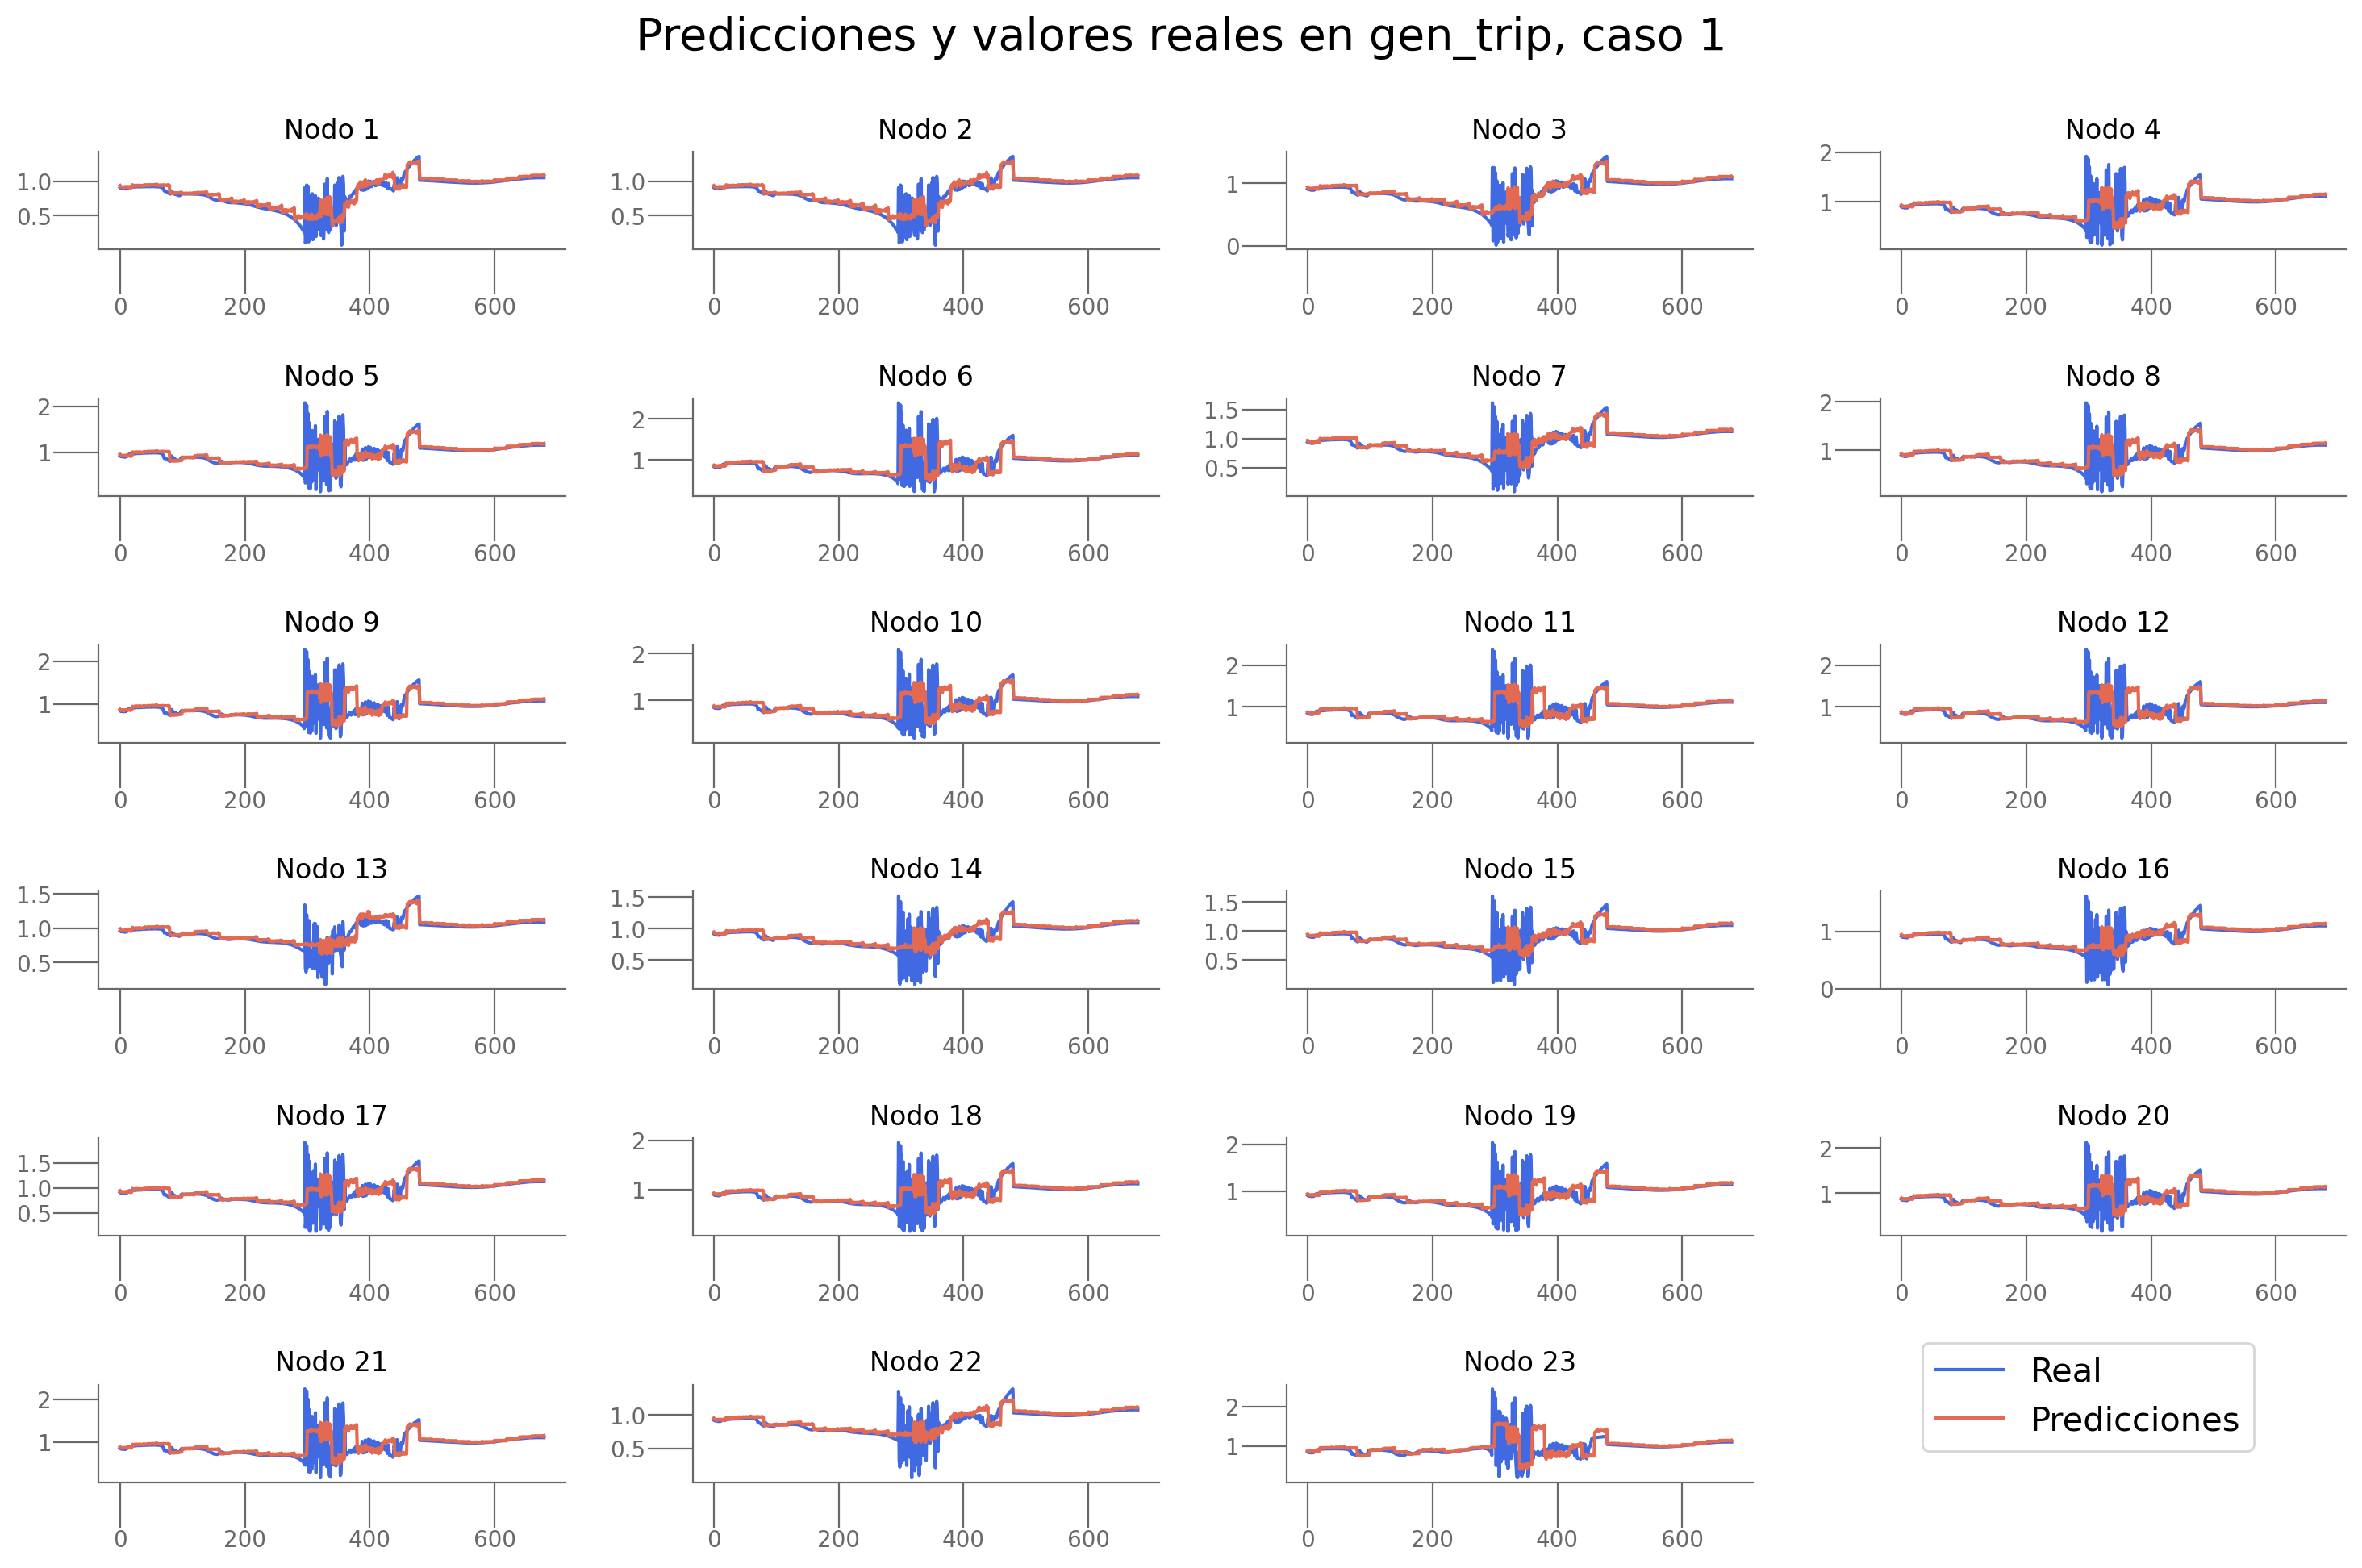

In [31]:
_,_,_, predictions_gt_ajuste,real_gt_ajuste = trainer_gt.test()
plot_predictions(predictions_gt_ajuste, real_gt_ajuste, n_target, 1, n_div_gt, problem_gt)

In [32]:
trainer_gt.save_model(path_save_experiment=path_save_experiment_gt, params = params_gt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1     MPNN_LSTM                {'hidden_size': 16, 'dropout': 0.2}   
2  LSTM_NOBATCH                                                NaN   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
6     EvolveGCN                                                NaN   
7         DCRNN                                     {'hidden': 10}   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.007638   0.204209   
1    ./results/gen_trip/ajustes/MPNNLSTM_results.csv  0.045889 -18.247558   
2                                                NaN  0.007437  -1.985579 

### Bus trip

In [33]:
problem_bt = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [34]:

n_div_bt = loader.div
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]
embedding_dim =5

#### Ajuste de parámetros

In [35]:
param_grid = {
    "hidden_size": [10,20,40,60]
}

trainer_bt,params_bt, resultados_final_bt, resultados_bt = entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset_bt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bt)

  0%|          | 0/4 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/50 | Train Loss: 0.6426 | Eval Loss: 0.4158 | Eval R2: -13.1233 | LR: 0.0010 | 
Epoch 2/50 | Train Loss: 0.2941 | Eval Loss: 0.1926 | Eval R2: -5.0360 | LR: 0.0010 | 
Epoch 3/50 | Train Loss: 0.1420 | Eval Loss: 0.0970 | Eval R2: -1.6671 | LR: 0.0010 | 
Epoch 4/50 | Train Loss: 0.0783 | Eval Loss: 0.0581 | Eval R2: -0.3923 | LR: 0.0010 | 


In [ ]:
path_save_experiment_bt = results_save_path+f"/{problem_bt}"+ f"/ajustes/{name_model}_results.csv"
resultados_bt.to_csv(path_save_experiment_bt, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.010180, test r2score 0.820992


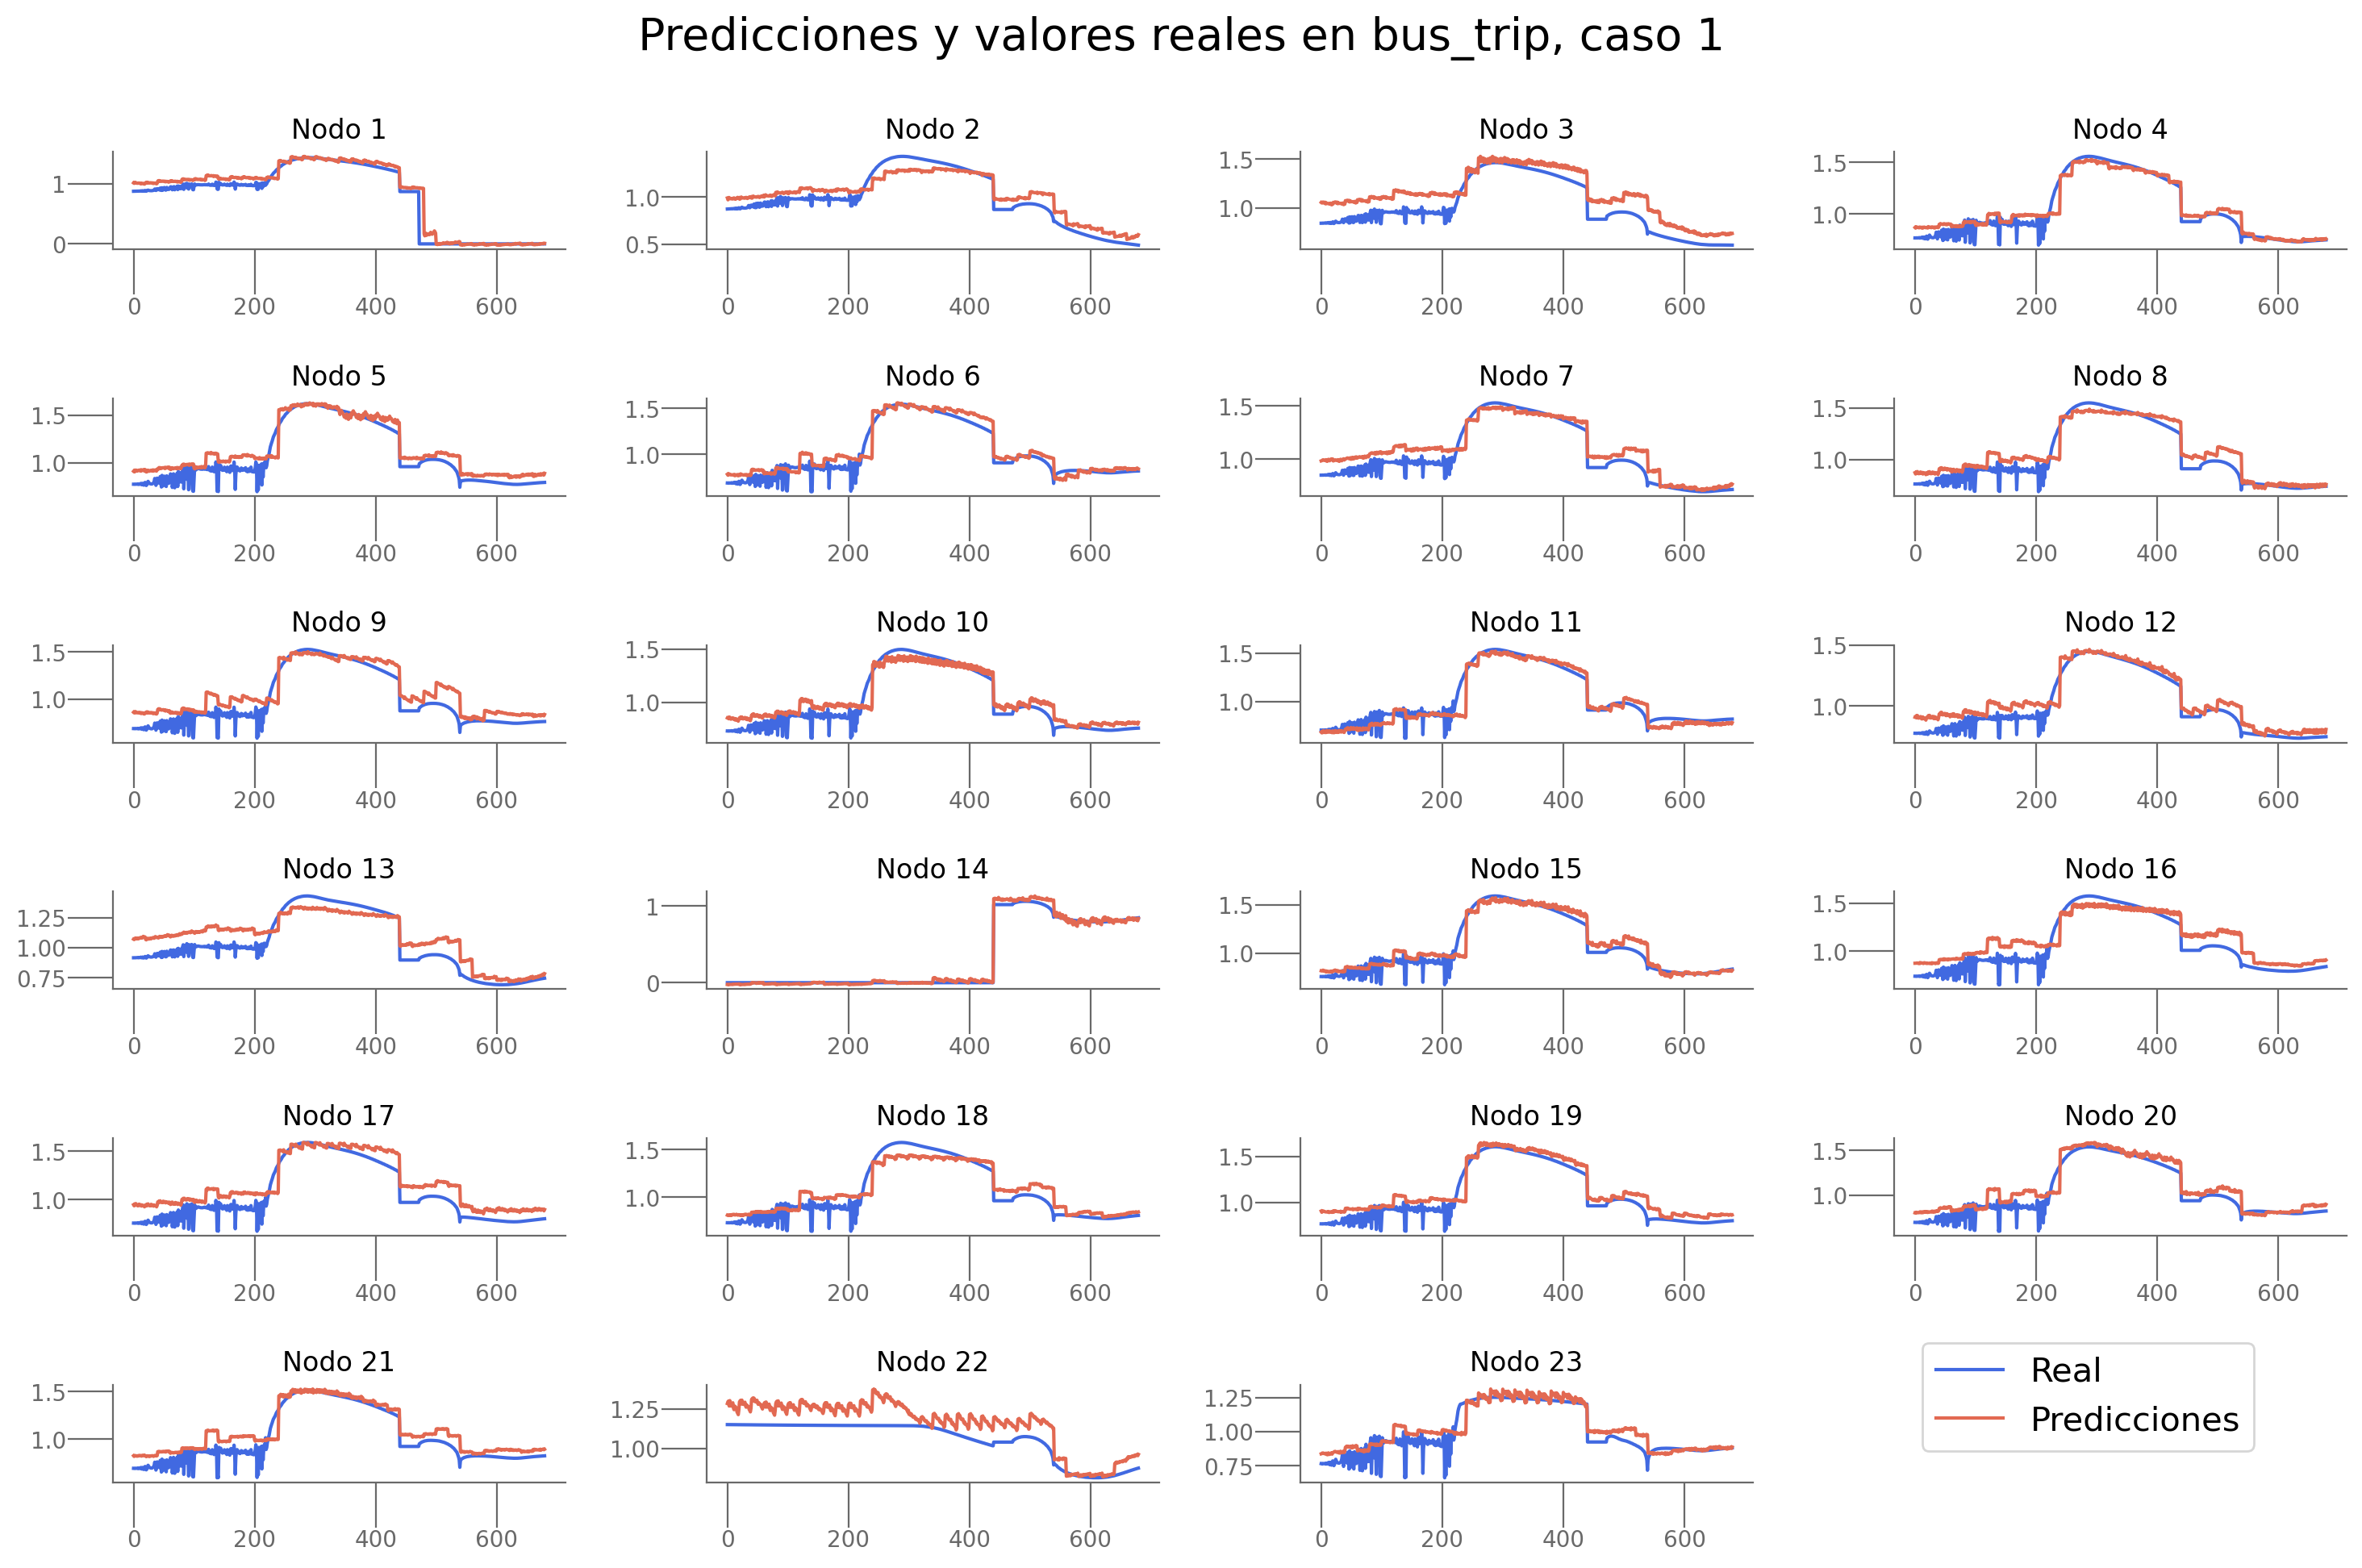

In [ ]:
_,_,_, predictions_bt_ajuste,real_bt_ajuste = trainer_bt.test()
plot_predictions(predictions_bt_ajuste, real_bt_ajuste, n_target, 1, n_div_bt, problem_bt)

In [ ]:
trainer_bt.save_model(path_save_experiment=path_save_experiment_bt, params = params_bt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                 Params  \
0          LSTM                                    NaN   
1  LSTM_NOBATCH                                    NaN   
2     MPNN_LSTM                              (32, 0.8)   
3   DyGrEncoder  {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         AGCRN                  {'hidden': 5, 'K': 2}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.005474  0.923150   
1                                                NaN  0.005606  0.865487   
2    ./results/bus_trip/ajustes/MPNNLSTM_results.csv  0.006753  0.845855   
3  ./results/bus_trip/ajustes/DryGrEncoder_result...  0.005348  0.827431   
4       ./results/bus_trip/ajustes/AGCRN_results.csv  0.010180  0.820992   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.00273813 0.00319852 0.00392416 0.00609108 0... 

### Bus fault

In [ ]:
problem_bf = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bf)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [ ]:

n_div_bf = loader.div
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
embedding_dim =5

#### Ajuste de parámetros

In [ ]:
param_grid = {
    "hidden_size": [10,20,40,60]
}

trainer_bf,params_bf, resultados_final_bf, resultados_bf = entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset_bf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bf)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 405
DataLoader for val set:
Number of batches: 87
DataLoader for test set:
Number of batches: 86

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1207 | Eval Loss: 0.0626 | Eval R2: -0.6043 | 
Epoch 2/30 | Train Loss: 0.0391 | Eval Loss: 0.0495 | Eval R2: -0.1507 | 
Epoch 3/30 | Train Loss: 0.0320 | Eval Loss: 0.0443 | Eval R2: 0.0102 | 
Epoch 4/30 | Train Loss: 0.0290 | Eval Loss: 0.0407 | Eval R2: 0.1004 | 
Epoch 5/30 | Train Loss: 0.0271 | Eval Loss: 0.0366 | Eval R2: 0.1969 | 
Epoch 6/30 | Train Loss: 0.0258 | Eval Loss: 0.0352 | Eval R2: 0.2177 | 
Epoch 7/30 | Train Loss: 0.0255 | Eval Loss: 0.0333 | Eval R2: 0.2680 | 
Epoch 8/30 | Train Loss: 0.0241 | Eval Loss: 0.0325 | Eval R2: 0.2932 | 
Epoch 9/30 | Train Loss: 0.0239 | Eval Lo

 11%|█         | 1/9 [02:34<20:33, 154.23s/it]

preds:  (5, 23, 20)
test loss: 0.020923, test r2score 0.246714
Parámetros:  5 2
Resultados:  {'Embedding': 5, 'k': 2, 'Loss_final': 0.018770625814795494, 'R2_eval': 0.4264502227306366, 'Loss_eval': 0.02698141150176525, 'R2_tst': 0.24671388995083032, 'Loss_tst': 0.020923113450407982, 'Loss_nodes': [0.016992485150694847, 0.01384352520108223, 0.014439519494771957, 0.020940085873007774, 0.0255841426551342, 0.026694566011428833, 0.016286320984363556, 0.026312869042158127, 0.044566117227077484, 0.023245319724082947, 0.02264423854649067, 0.015178516507148743, 0.01020783931016922, 0.015123194083571434, 0.015088084153831005, 0.017192833125591278, 0.023412534967064857, 0.025513337925076485, 0.02115403115749359, 0.023692114278674126, 0.028317367658019066, 0.015177416615188122, 0.019625164568424225]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train se

 22%|██▏       | 2/9 [05:33<19:41, 168.84s/it]

preds:  (5, 23, 20)
test loss: 0.023988, test r2score 0.010954
Parámetros:  5 3
Resultados:  {'Embedding': 5, 'k': 3, 'Loss_final': 0.02056192047894001, 'R2_eval': 0.31301194429397583, 'Loss_eval': 0.030431585386395454, 'R2_tst': 0.010954467661154503, 'Loss_tst': 0.02398768439888954, 'Loss_nodes': [0.014206979423761368, 0.017107194289565086, 0.02093016356229782, 0.023861141875386238, 0.03181431069970131, 0.03200589120388031, 0.017000477761030197, 0.022541480138897896, 0.03570063039660454, 0.027733370661735535, 0.024927038699388504, 0.018635112792253494, 0.018215391784906387, 0.01519379485398531, 0.02179328165948391, 0.024411112070083618, 0.025037221610546112, 0.04257917031645775, 0.02515527606010437, 0.026043398305773735, 0.03250667452812195, 0.014992447569966316, 0.01932518184185028]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:


 33%|███▎      | 3/9 [08:48<18:05, 180.91s/it]

preds:  (5, 23, 20)
test loss: 0.029383, test r2score -0.143166
Parámetros:  5 4
Resultados:  {'Embedding': 5, 'k': 4, 'Loss_final': 0.023920468986034393, 'R2_eval': 0.15168437361717224, 'Loss_eval': 0.036637090146541595, 'R2_tst': -0.14316566265465777, 'Loss_tst': 0.029383398592472076, 'Loss_nodes': [0.021893667057156563, 0.0254148468375206, 0.020818214863538742, 0.030248017981648445, 0.04393261671066284, 0.039167407900094986, 0.021462930366396904, 0.029987476766109467, 0.03593675047159195, 0.027021588757634163, 0.029814038425683975, 0.02112601511180401, 0.016389766708016396, 0.03455718606710434, 0.024073131382465363, 0.028771424666047096, 0.04396500065922737, 0.030160538852214813, 0.02582857757806778, 0.03081815131008625, 0.04353736340999603, 0.026575112715363503, 0.024318350479006767]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train se

 44%|████▍     | 4/9 [11:31<14:29, 173.89s/it]

preds:  (5, 23, 20)
test loss: 0.030919, test r2score -0.499721
Parámetros:  10 2
Resultados:  {'Embedding': 10, 'k': 2, 'Loss_final': 0.022026749327778816, 'R2_eval': -0.012862435542047024, 'Loss_eval': 0.03685781732201576, 'R2_tst': -0.49972059268285374, 'Loss_tst': 0.03091871552169323, 'Loss_nodes': [0.023447971791028976, 0.018008964136242867, 0.027659865096211433, 0.02499457076191902, 0.03226639702916145, 0.03609295189380646, 0.04013296589255333, 0.024099189788103104, 0.030427919700741768, 0.03466454893350601, 0.07997553795576096, 0.021579351276159286, 0.018921637907624245, 0.018267689272761345, 0.023019658401608467, 0.02975841425359249, 0.04064764454960823, 0.024306295439600945, 0.06316223740577698, 0.02880127727985382, 0.02965490147471428, 0.021581701934337616, 0.019658779725432396]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train s

 56%|█████▌    | 5/9 [14:29<11:41, 175.34s/it]

preds:  (5, 23, 20)
test loss: 0.036473, test r2score -0.691844
Parámetros:  10 3
Resultados:  {'Embedding': 10, 'k': 3, 'Loss_final': 0.026105035096406937, 'R2_eval': -0.08334165066480637, 'Loss_eval': 0.04254904389381409, 'R2_tst': -0.6918442662981875, 'Loss_tst': 0.03647274896502495, 'Loss_nodes': [0.026459278538823128, 0.05220179632306099, 0.030893869698047638, 0.03331698477268219, 0.03740989789366722, 0.036007605493068695, 0.04091784358024597, 0.05647978559136391, 0.041043251752853394, 0.046251311898231506, 0.03909871727228165, 0.021435419097542763, 0.013547535985708237, 0.02352813258767128, 0.030384501442313194, 0.040087174624204636, 0.038296401500701904, 0.03671499341726303, 0.03520340099930763, 0.04216115549206734, 0.049234695732593536, 0.027902716770768166, 0.04029674082994461]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set

 67%|██████▋   | 6/9 [17:07<08:28, 169.42s/it]

preds:  (5, 23, 20)
test loss: 0.042699, test r2score -1.417489
Parámetros:  10 4
Resultados:  {'Embedding': 10, 'k': 4, 'Loss_final': 0.029046736657619476, 'R2_eval': -0.21471214294433594, 'Loss_eval': 0.0462760254740715, 'R2_tst': -1.4174892031679522, 'Loss_tst': 0.042699072510004044, 'Loss_nodes': [0.0731356143951416, 0.04810701310634613, 0.04642007499933243, 0.03949389234185219, 0.051002539694309235, 0.06321564316749573, 0.04328200966119766, 0.050559546798467636, 0.04129675403237343, 0.03052469529211521, 0.04216055944561958, 0.024930942803621292, 0.022938568145036697, 0.02850247547030449, 0.025521522387862206, 0.07538285106420517, 0.07189376652240753, 0.03299471363425255, 0.03573095425963402, 0.04011281579732895, 0.03761093318462372, 0.03257334232330322, 0.024687467142939568]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:
Numbe

 78%|███████▊  | 7/9 [19:23<05:16, 158.44s/it]

preds:  (5, 23, 20)
test loss: 0.035582, test r2score -0.880195
Parámetros:  15 2
Resultados:  {'Embedding': 15, 'k': 2, 'Loss_final': 0.026162711903452873, 'R2_eval': -0.14212068915367126, 'Loss_eval': 0.04373551532626152, 'R2_tst': -0.8801950313107284, 'Loss_tst': 0.035581961274147034, 'Loss_nodes': [0.015266279689967632, 0.03107626549899578, 0.04338199645280838, 0.029353821650147438, 0.03172218054533005, 0.04510991647839546, 0.022663189098238945, 0.0273071750998497, 0.044273678213357925, 0.046438056975603104, 0.036798056215047836, 0.026272837072610855, 0.028351791203022003, 0.02644936367869377, 0.05081242695450783, 0.03014031983911991, 0.058351196348667145, 0.039073556661605835, 0.051990970969200134, 0.05311195179820061, 0.0290356632322073, 0.015413639135658741, 0.03599083051085472]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:

 89%|████████▉ | 8/9 [21:53<02:35, 155.90s/it]

preds:  (5, 23, 20)
test loss: 0.038814, test r2score -0.872943
Parámetros:  15 3
Resultados:  {'Embedding': 15, 'k': 3, 'Loss_final': 0.029529355466365814, 'R2_eval': -0.09584757685661316, 'Loss_eval': 0.04452681168913841, 'R2_tst': -0.8729431622635987, 'Loss_tst': 0.03881417214870453, 'Loss_nodes': [0.03815332055091858, 0.03704902157187462, 0.028027808293700218, 0.038712140172719955, 0.036232493817806244, 0.057889606803655624, 0.042401205748319626, 0.041543006896972656, 0.04204711690545082, 0.03920845314860344, 0.04657416045665741, 0.03138691186904907, 0.02602255903184414, 0.0341402143239975, 0.028430534526705742, 0.05338332802057266, 0.046438854187726974, 0.0360732227563858, 0.038209810853004456, 0.058573510497808456, 0.04061220958828926, 0.025505779311060905, 0.026110712438821793]}

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:


100%|██████████| 9/9 [24:29<00:00, 163.27s/it]

preds:  (5, 23, 20)
test loss: 0.037931, test r2score -0.679503
Parámetros:  15 4
Resultados:  {'Embedding': 15, 'k': 4, 'Loss_final': 0.03144180774688721, 'R2_eval': -0.1436217874288559, 'Loss_eval': 0.045718707144260406, 'R2_tst': -0.6795026464132614, 'Loss_tst': 0.03793061152100563, 'Loss_nodes': [0.019832037389278412, 0.0295146144926548, 0.0419611930847168, 0.03710000589489937, 0.04143337160348892, 0.037077777087688446, 0.03435059264302254, 0.03201206773519516, 0.039757248014211655, 0.044591180980205536, 0.05748220533132553, 0.057750314474105835, 0.022033752873539925, 0.0368177555501461, 0.03011206164956093, 0.031016793102025986, 0.049367256462574005, 0.043448593467473984, 0.038569990545511246, 0.040536362677812576, 0.058096934109926224, 0.019394060596823692, 0.030147934332489967]}


In [ ]:
path_save_experiment_bf = results_save_path+f"/{problem_bf}"+ f"/ajustes/{name_model}_results.csv"
resultados_bf.to_csv(path_save_experiment_bf, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.020923, test r2score 0.246714


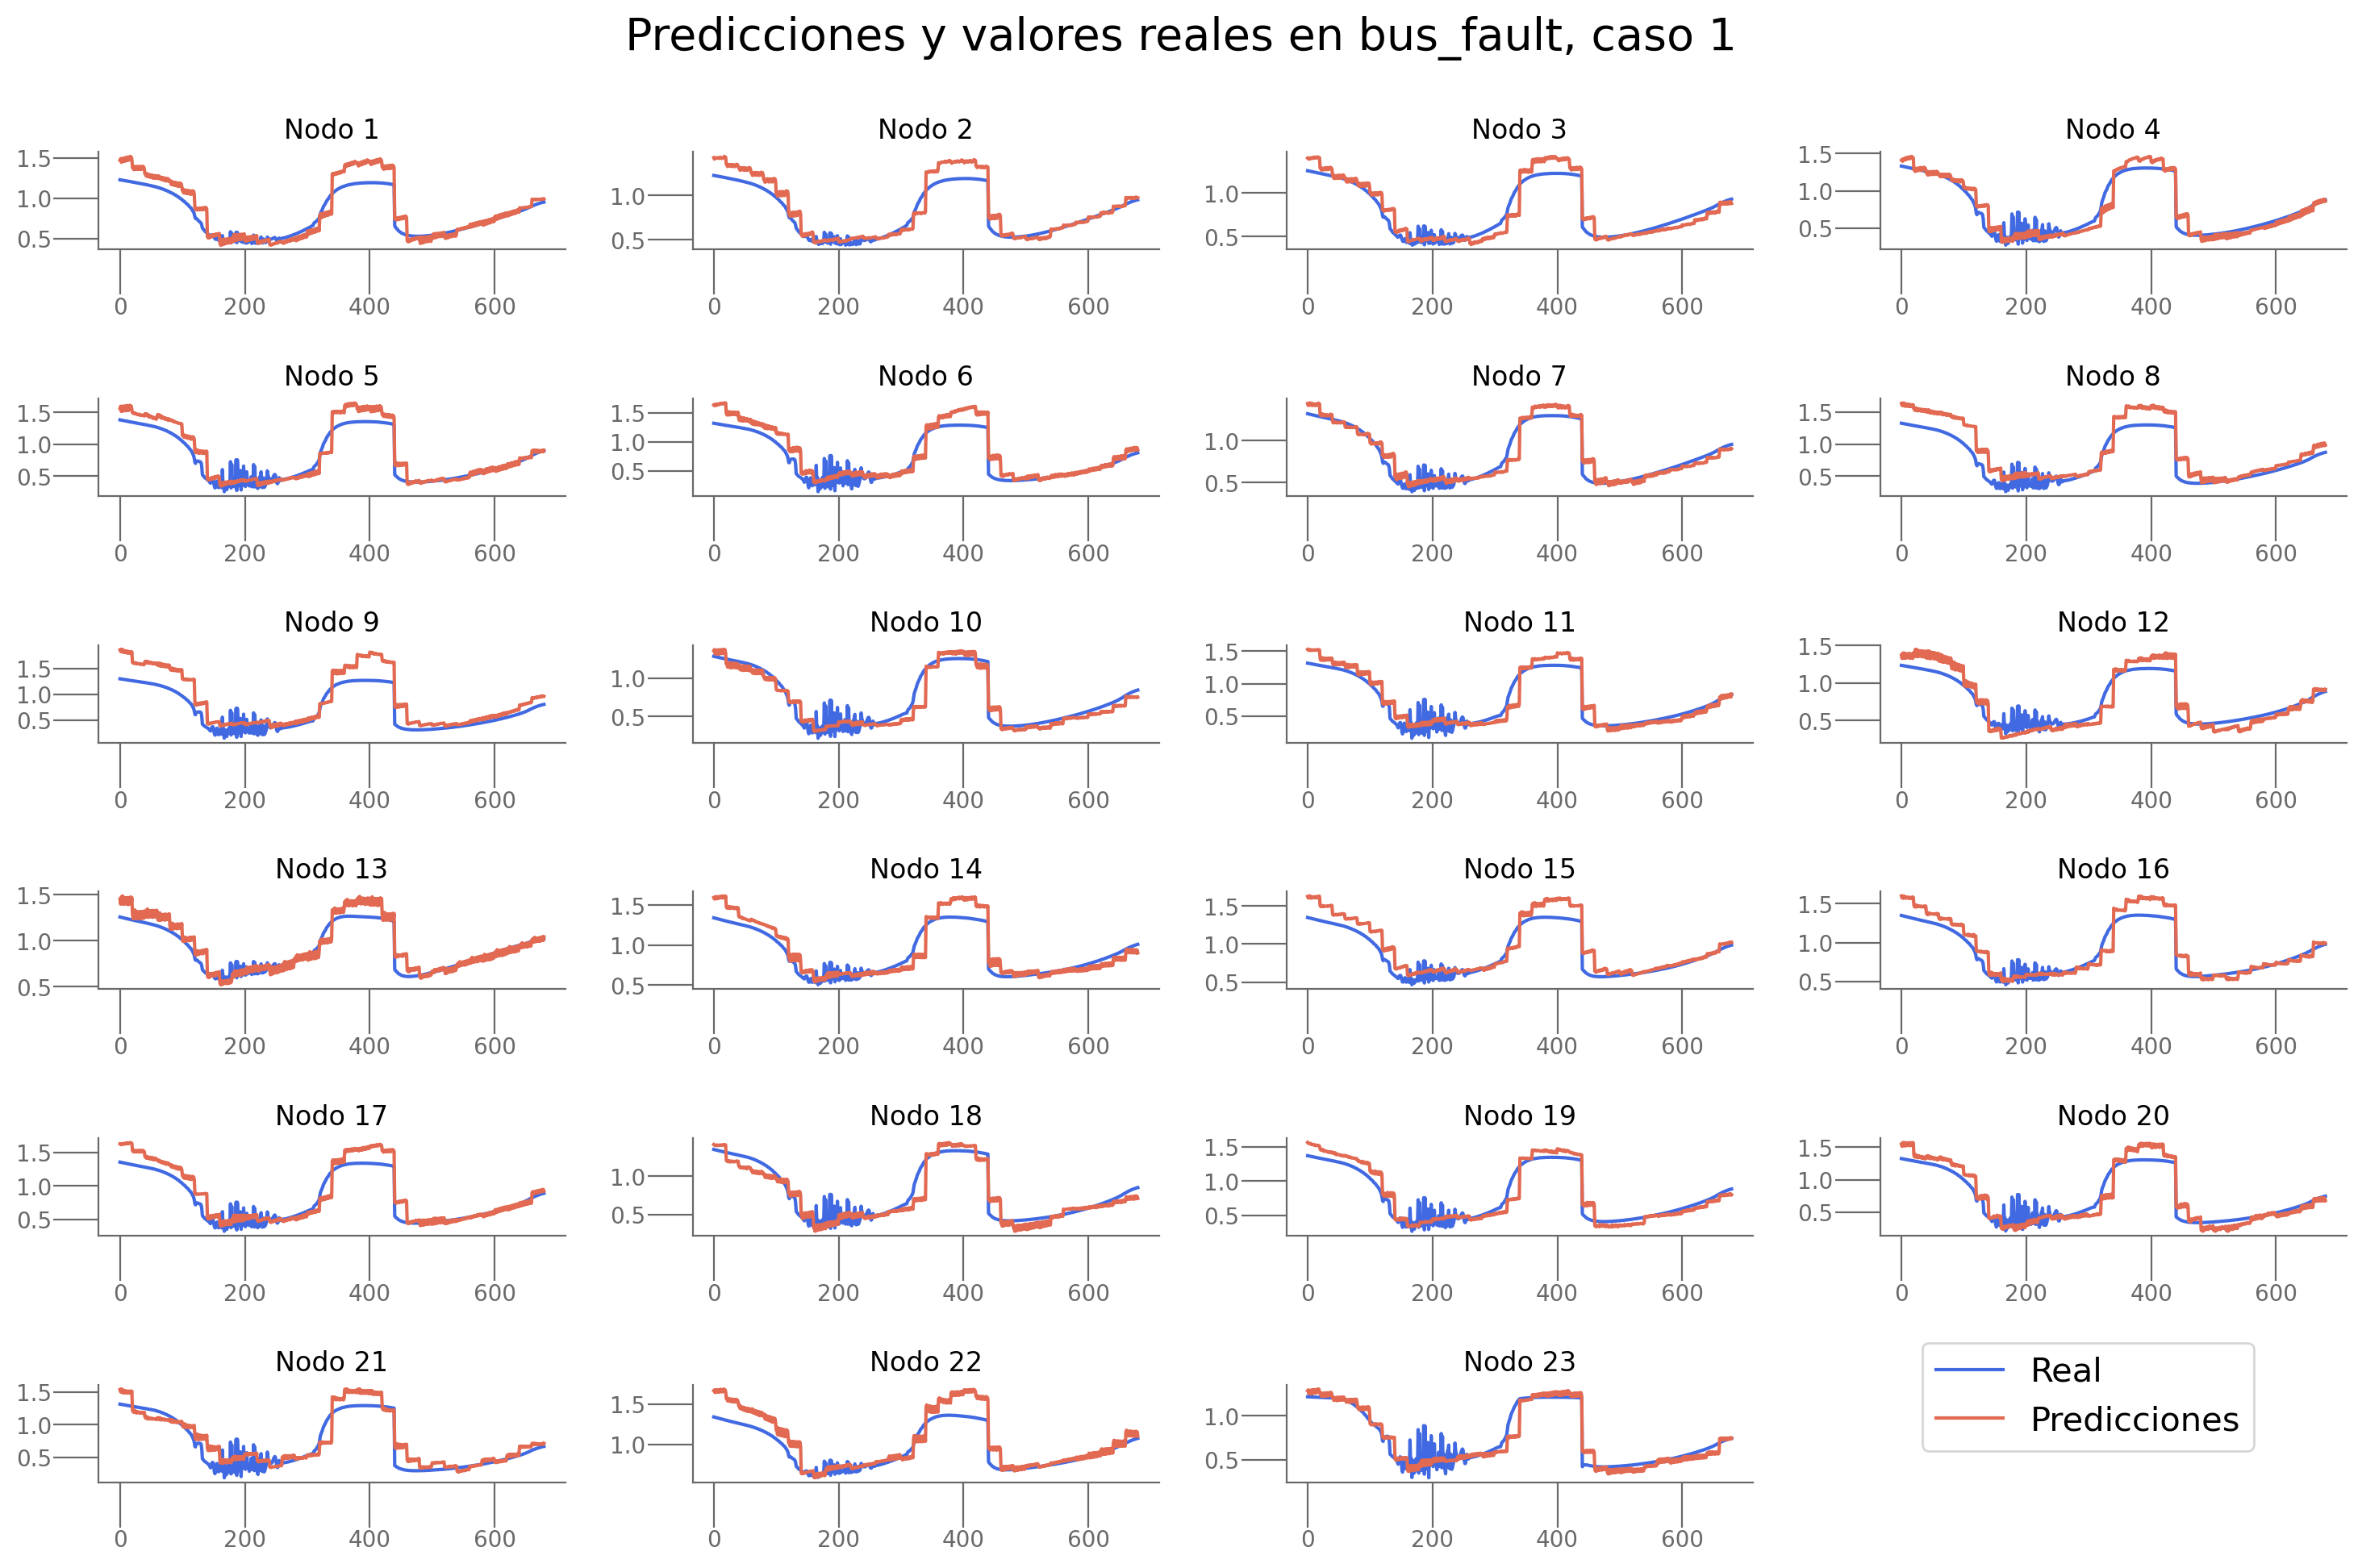

In [ ]:
_,_,_, predictions_bf_ajuste,real_bf_ajuste = trainer_bf.test()
plot_predictions(predictions_bf_ajuste, real_bf_ajuste, n_target, 1, n_div_bf, problem_bf)

In [ ]:
trainer_bf.save_model(path_save_experiment=path_save_experiment_bf, params = params_bf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                  Params  \
0          LSTM                                     NaN   
1  LSTM_NOBATCH                                     NaN   
2     MPNN_LSTM     {'hidden_size': 64, 'dropout': 0.2}   
3   DyGrEncoder  {'aggr': 'mean', 'conv': 1, 'lstm': 1}   
4         AGCRN                   {'hidden': 5, 'K': 2}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.017298  0.603716   
1                                                NaN  0.017459 -1.122112   
2   ./results/bus_fault/ajustes/MPNNLSTM_results.csv  0.016746 -0.682421   
3  ./results/bus_fault/ajustes/DryGrEncoder_resul...  0.016410 -0.664772   
4      ./results/bus_fault/ajustes/AGCRN_results.csv  0.020923  0.246714   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.0107881  0.01006583 0.01300934 0.01969145

### Branch Fault

In [ ]:
problem_brf = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [ ]:

n_div_brf = loader.div
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
embedding_dim =5

#### Ajuste de parámetros

In [ ]:
param_grid = {
    "hidden_size": [10,20,40,60]
}

trainer_brf,params_brf, resultados_final_brf, resultados_brf = entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset_brf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brf)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 432
DataLoader for val set:
Number of batches: 93
DataLoader for test set:
Number of batches: 93

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1042 | Eval Loss: 0.0697 | Eval R2: -0.5333 | 
Epoch 2/30 | Train Loss: 0.0390 | Eval Loss: 0.0545 | Eval R2: -0.0209 | 
Epoch 3/30 | Train Loss: 0.0328 | Eval Loss: 0.0475 | Eval R2: 0.1849 | 
Epoch 4/30 | Train Loss: 0.0301 | Eval Loss: 0.0462 | Eval R2: 0.2308 | 
Epoch 5/30 | Train Loss: 0.0282 | Eval Loss: 0.0436 | Eval R2: 0.2970 | 
Epoch 6/30 | Train Loss: 0.0271 | Eval Loss: 0.0419 | Eval R2: 0.3361 | 
Epoch 7/30 | Train Loss: 0.0262 | Eval Loss: 0.0373 | Eval R2: 0.4340 | 
Epoch 8/30 | Train Loss: 0.0250 | Eval Loss: 0.0373 | Eval R2: 0.4338 | 
Epoch 9/30 | Train Loss: 0.0242 | Eval Lo

 11%|█         | 1/9 [02:26<19:34, 146.85s/it]

preds:  (5, 23, 20)
test loss: 0.024755, test r2score 0.589204
Parámetros:  5 2
Resultados:  {'Embedding': 5, 'k': 2, 'Loss_final': 0.020443059504032135, 'R2_eval': 0.5496549010276794, 'Loss_eval': 0.031148098409175873, 'R2_tst': 0.5892036493019402, 'Loss_tst': 0.024754729121923447, 'Loss_nodes': [0.010145576670765877, 0.010636339895427227, 0.01231576781719923, 0.023087482899427414, 0.02885381132364273, 0.03221428766846657, 0.01976427249610424, 0.023753052577376366, 0.031495653092861176, 0.03214947506785393, 0.0304098017513752, 0.018932418897747993, 0.011343354359269142, 0.023904230445623398, 0.02539544180035591, 0.029802914708852768, 0.0309867262840271, 0.032732464373111725, 0.02867010608315468, 0.031170232221484184, 0.03356444835662842, 0.0220576673746109, 0.025973279029130936]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Numbe

 22%|██▏       | 2/9 [05:13<18:28, 158.33s/it]

preds:  (5, 23, 20)
test loss: 0.033839, test r2score 0.377649
Parámetros:  5 3
Resultados:  {'Embedding': 5, 'k': 3, 'Loss_final': 0.021764643490314484, 'R2_eval': 0.33498838543891907, 'Loss_eval': 0.04060133174061775, 'R2_tst': 0.37764857848088235, 'Loss_tst': 0.033839352428913116, 'Loss_nodes': [0.016817446798086166, 0.011924448423087597, 0.020279524847865105, 0.02886754460632801, 0.03955983743071556, 0.04066982865333557, 0.01720556616783142, 0.031664494425058365, 0.03875529021024704, 0.051586706191301346, 0.03581557050347328, 0.02818138711154461, 0.024342352524399757, 0.039670269936323166, 0.034175146371126175, 0.04249907657504082, 0.04110192134976387, 0.0377361960709095, 0.03697953000664711, 0.044080860912799835, 0.04587024822831154, 0.03196736425161362, 0.03855450078845024]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Numbe

 33%|███▎      | 3/9 [08:33<17:45, 177.61s/it]

preds:  (5, 23, 20)
test loss: 0.032238, test r2score 0.417838
Parámetros:  5 4
Resultados:  {'Embedding': 5, 'k': 4, 'Loss_final': 0.02348574623465538, 'R2_eval': 0.3282620906829834, 'Loss_eval': 0.040488019585609436, 'R2_tst': 0.417838353880689, 'Loss_tst': 0.03223838284611702, 'Loss_nodes': [0.01948154903948307, 0.014856651425361633, 0.0238154549151659, 0.033915139734745026, 0.03738779574632645, 0.03781956806778908, 0.022608768194913864, 0.032818395644426346, 0.036735650151968, 0.03587281331419945, 0.033769067376852036, 0.026566701009869576, 0.01936083287000656, 0.03469761833548546, 0.040499262511730194, 0.03405870869755745, 0.03952816128730774, 0.044156089425086975, 0.029790101572871208, 0.037004102021455765, 0.03721529617905617, 0.03271942958235741, 0.036805544048547745]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of

 44%|████▍     | 4/9 [11:38<15:02, 180.44s/it]

preds:  (5, 23, 20)
test loss: 0.030708, test r2score 0.445883
Parámetros:  10 2
Resultados:  {'Embedding': 10, 'k': 2, 'Loss_final': 0.022988179698586464, 'R2_eval': 0.3997238874435425, 'Loss_eval': 0.037628162652254105, 'R2_tst': 0.4458828213093409, 'Loss_tst': 0.030708085745573044, 'Loss_nodes': [0.012461021542549133, 0.010766291990876198, 0.030550215393304825, 0.027126973494887352, 0.038695093244314194, 0.04081312566995621, 0.02487669698894024, 0.030454589053988457, 0.0394040085375309, 0.03367132321000099, 0.03297017887234688, 0.023493697866797447, 0.0125050600618124, 0.03229936212301254, 0.03814665228128433, 0.03873853385448456, 0.03536251187324524, 0.034004464745521545, 0.042939040809869766, 0.03517855703830719, 0.037645962089300156, 0.028024768456816673, 0.026157816872000694]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Nu

 56%|█████▌    | 5/9 [15:09<12:45, 191.27s/it]

preds:  (5, 23, 20)
test loss: 0.038476, test r2score 0.264975
Parámetros:  10 3
Resultados:  {'Embedding': 10, 'k': 3, 'Loss_final': 0.026981592178344727, 'R2_eval': 0.13961541652679443, 'Loss_eval': 0.04864353686571121, 'R2_tst': 0.26497458717993033, 'Loss_tst': 0.038475774228572845, 'Loss_nodes': [0.01055184192955494, 0.011702415533363819, 0.04313249886035919, 0.03971467912197113, 0.037828486412763596, 0.05210030451416969, 0.0324387401342392, 0.03586096689105034, 0.04406818374991417, 0.025123488157987595, 0.04971347376704216, 0.03226039558649063, 0.010593649931252003, 0.04506944864988327, 0.0440499484539032, 0.048773180693387985, 0.08631283789873123, 0.04358337074518204, 0.03850233554840088, 0.04180969297885895, 0.040290359407663345, 0.03197602555155754, 0.039486538618803024]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Number

 67%|██████▋   | 6/9 [18:43<09:57, 199.17s/it]

preds:  (5, 23, 20)
test loss: 0.037445, test r2score 0.270975
Parámetros:  10 4
Resultados:  {'Embedding': 10, 'k': 4, 'Loss_final': 0.027697013691067696, 'R2_eval': 0.14525297284126282, 'Loss_eval': 0.04716164246201515, 'R2_tst': 0.270974869665674, 'Loss_tst': 0.03744494915008545, 'Loss_nodes': [0.012865982949733734, 0.015782542526721954, 0.024848787114024162, 0.038524024188518524, 0.04462756961584091, 0.0480508953332901, 0.031483475118875504, 0.03681309148669243, 0.05958651378750801, 0.029534317553043365, 0.048604853451251984, 0.03476589918136597, 0.015432950109243393, 0.037330422550439835, 0.038059718906879425, 0.034413233399391174, 0.04635429382324219, 0.048999447375535965, 0.037689611315727234, 0.054879773408174515, 0.0413999930024147, 0.030227523297071457, 0.050958916544914246]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:


 78%|███████▊  | 7/9 [21:42<06:25, 192.60s/it]

preds:  (5, 23, 20)
test loss: 0.042184, test r2score 0.164844
Parámetros:  15 2
Resultados:  {'Embedding': 15, 'k': 2, 'Loss_final': 0.026842989027500153, 'R2_eval': 0.09817779809236526, 'Loss_eval': 0.05037771165370941, 'R2_tst': 0.16484441659975502, 'Loss_tst': 0.042183924466371536, 'Loss_nodes': [0.08655216544866562, 0.025010600686073303, 0.03554341197013855, 0.03243247792124748, 0.04291154816746712, 0.052564747631549835, 0.021449778228998184, 0.035056471824645996, 0.035586923360824585, 0.03134990110993385, 0.03515932708978653, 0.02284407429397106, 0.022969655692577362, 0.03433620557188988, 0.054305944591760635, 0.07209543883800507, 0.03942331671714783, 0.05611270293593407, 0.04523666948080063, 0.047058556228876114, 0.05445493757724762, 0.03491276130080223, 0.052862707525491714]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Nu

 89%|████████▉ | 8/9 [25:00<03:14, 194.13s/it]

preds:  (5, 23, 20)
test loss: 0.041152, test r2score 0.209861
Parámetros:  15 3
Resultados:  {'Embedding': 15, 'k': 3, 'Loss_final': 0.03071345016360283, 'R2_eval': 0.11591728776693344, 'Loss_eval': 0.049181871116161346, 'R2_tst': 0.209860765345103, 'Loss_tst': 0.04115162417292595, 'Loss_nodes': [0.026963070034980774, 0.027377784252166748, 0.027449287474155426, 0.044539764523506165, 0.04504593089222908, 0.04262951761484146, 0.028468716889619827, 0.05046921223402023, 0.04665498808026314, 0.03656090795993805, 0.04657500609755516, 0.046593956649303436, 0.020258119329810143, 0.049559351056814194, 0.05134870857000351, 0.03833781182765961, 0.05262961611151695, 0.043485939502716064, 0.04124999791383743, 0.04534323140978813, 0.047644563019275665, 0.045197829604148865, 0.042104024440050125]}

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Nu

100%|██████████| 9/9 [28:31<00:00, 190.21s/it]

preds:  (5, 23, 20)
test loss: 0.046526, test r2score 0.027372
Parámetros:  15 4
Resultados:  {'Embedding': 15, 'k': 4, 'Loss_final': 0.031947061419487, 'R2_eval': -0.010777455754578114, 'Loss_eval': 0.05462354049086571, 'R2_tst': 0.02737176058572198, 'Loss_tst': 0.04652628302574158, 'Loss_nodes': [0.0176275372505188, 0.02019132673740387, 0.03381665423512459, 0.05749892815947533, 0.05499552562832832, 0.04969015344977379, 0.033561717718839645, 0.048403531312942505, 0.06028815358877182, 0.05954083055257797, 0.04956529289484024, 0.03421732038259506, 0.019342826679348946, 0.04533009231090546, 0.061281535774469376, 0.053645383566617966, 0.056010644882917404, 0.05488761141896248, 0.04589541628956795, 0.06531074643135071, 0.05450880527496338, 0.052555449306964874, 0.041938941925764084]}


In [ ]:
path_save_experiment_brf = results_save_path+f"/{problem_brf}"+ f"/ajustes/{name_model}_results.csv"
resultados_brf.to_csv(path_save_experiment_brf, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.024755, test r2score 0.589204


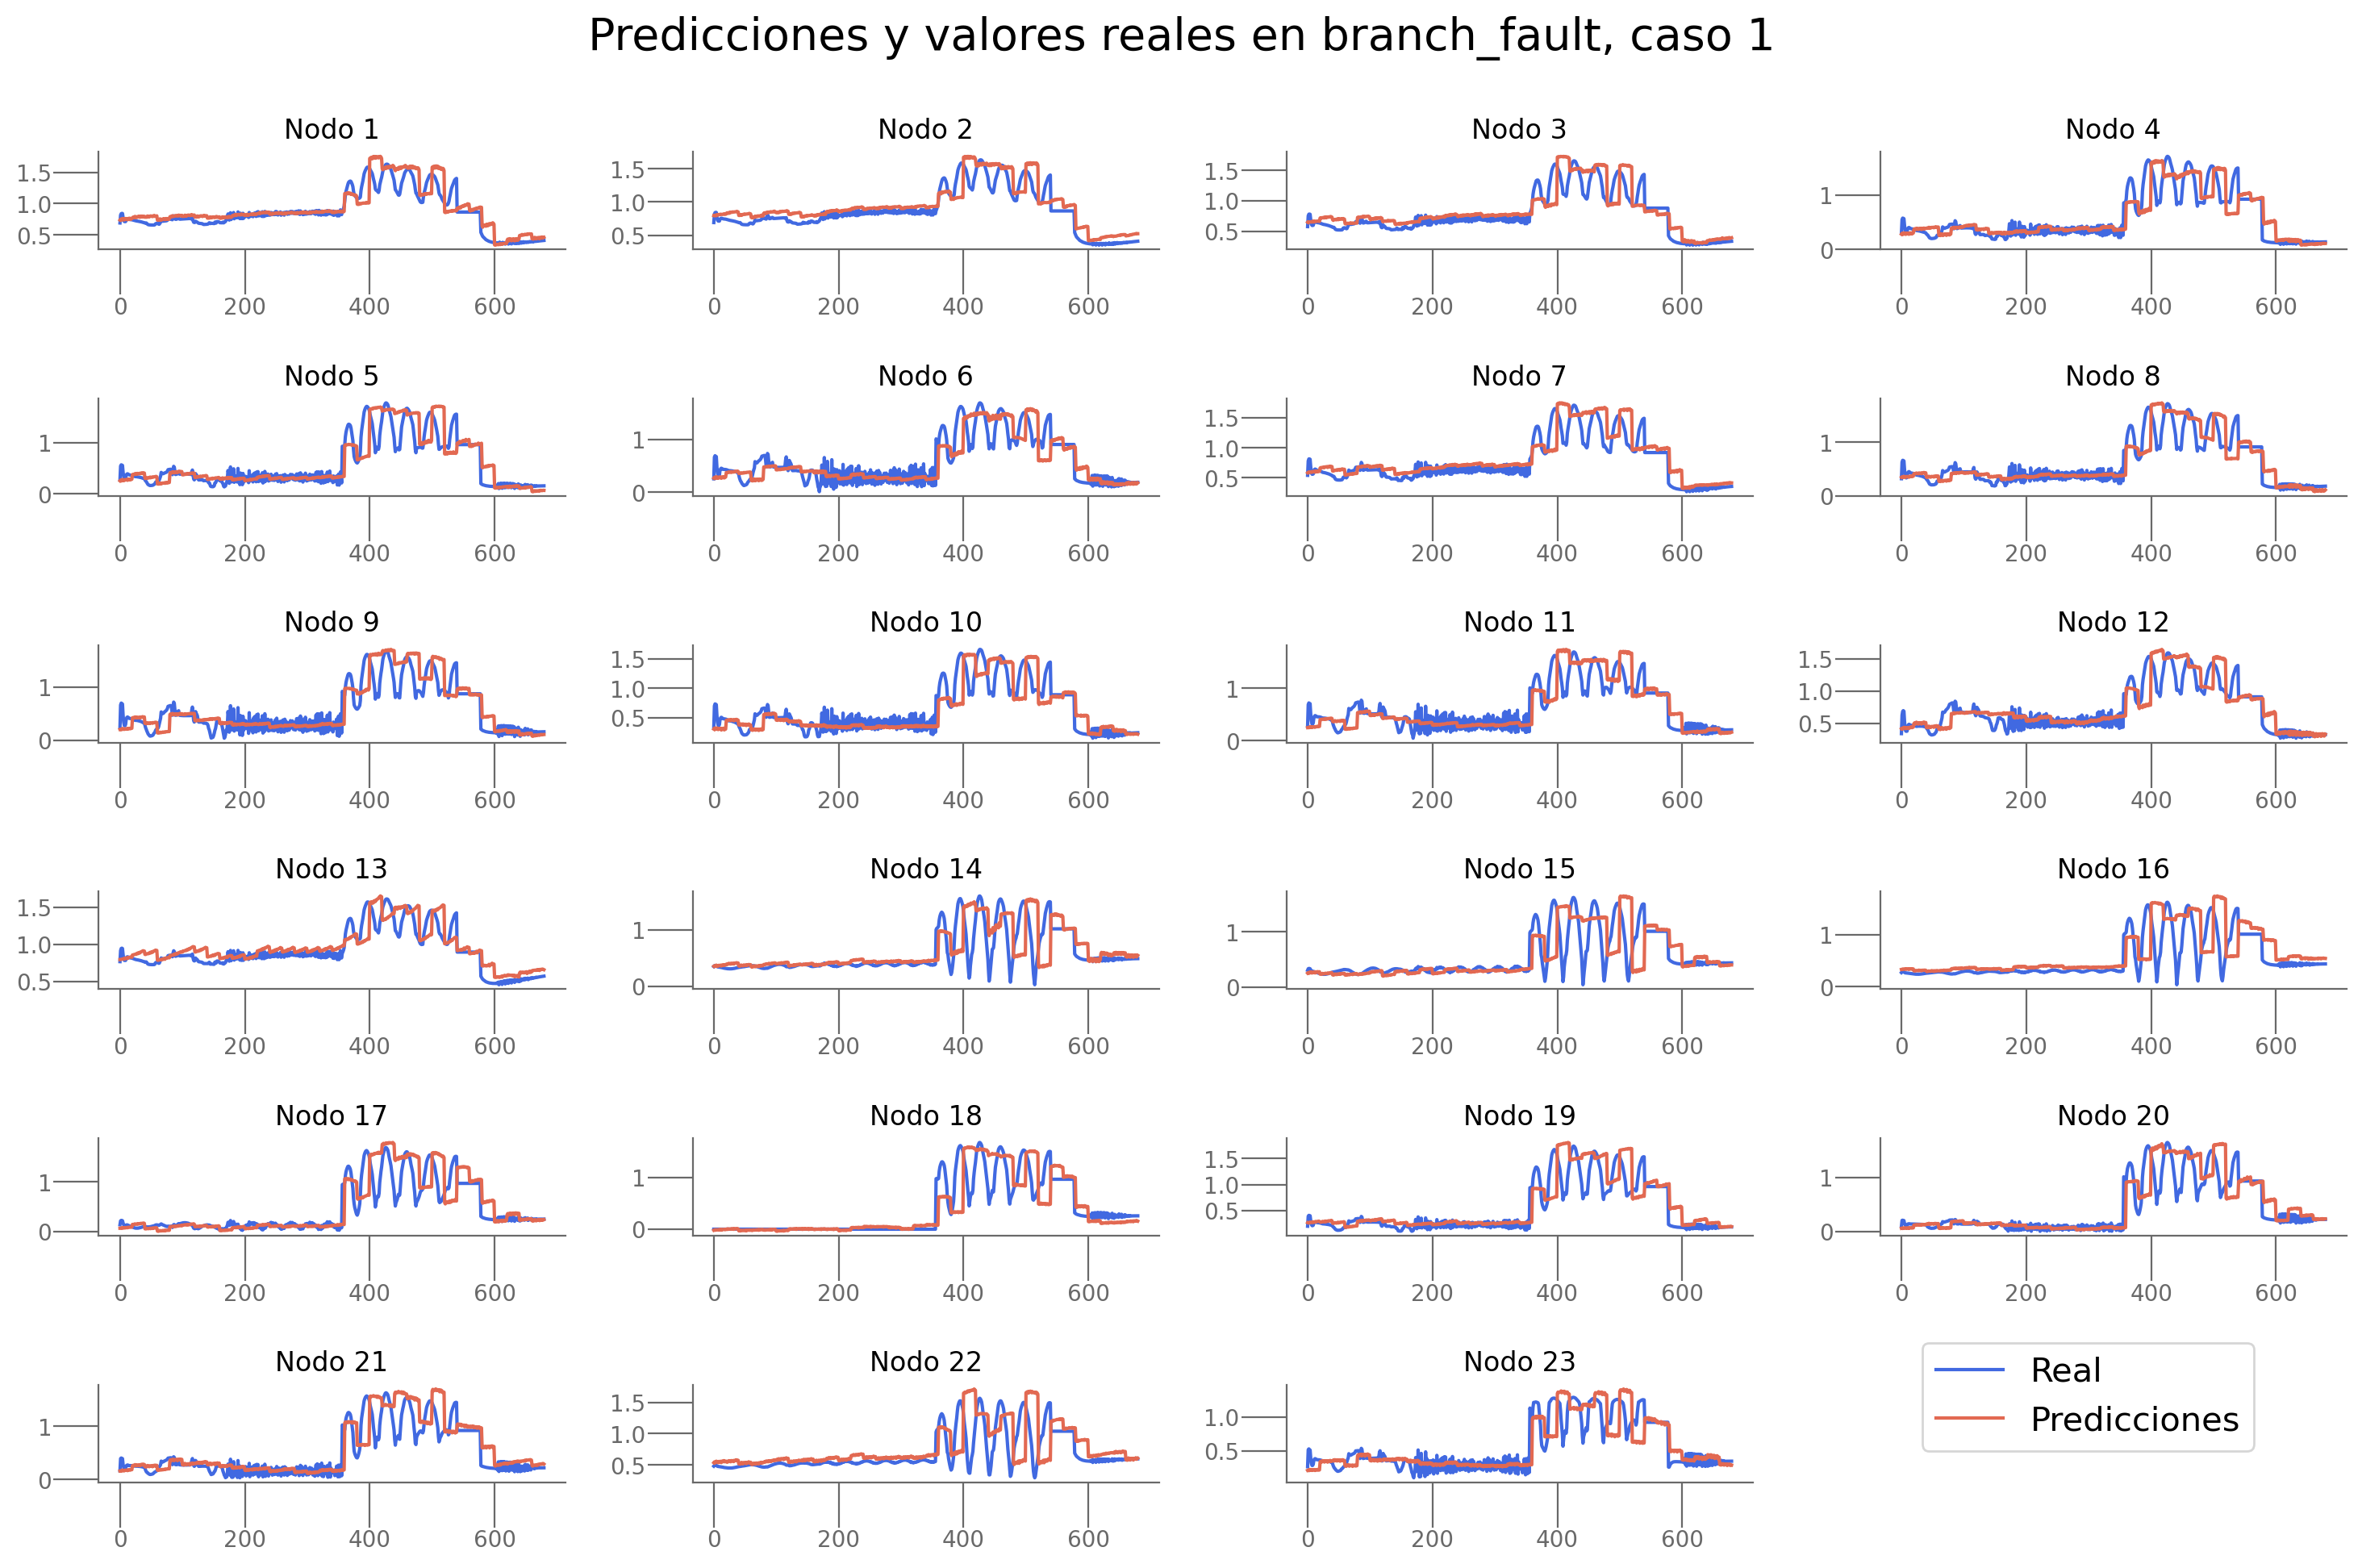

In [ ]:
_,_,_, predictions_brf_ajuste,real_brf_ajuste = trainer_brf.test()
plot_predictions(predictions_brf_ajuste, real_brf_ajuste, n_target, 1, n_div_brf, problem_brf)

In [ ]:
trainer_brf.save_model(path_save_experiment=path_save_experiment_brf, params = params_brf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                 Params  \
0          LSTM                                    NaN   
1  LSTM_NOBATCH                                    NaN   
2   DyGrEncoder  {'aggr': 'add', 'conv': 1, 'lstm': 1}   
3     MPNN_LSTM    {'hidden_size': 64, 'dropout': 0.2}   
4         AGCRN                  {'hidden': 5, 'K': 2}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.023216  0.608045   
1                                                NaN  0.021628 -1.528487   
2  ./results/branch_fault/ajustes/DryGrEncoder_re...  0.020580 -1.669938   
3  ./results/branch_fault/ajustes/MPNNLSTM_result...  0.021592 -1.565135   
4   ./results/branch_fault/ajustes/AGCRN_results.csv  0.024755  0.589204   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.01155095 0.00907443 0.01350776 0.02466182 0... 

### Branch trip

In [ ]:
problem_brt = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [ ]:

n_div_brt = loader.div
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
embedding_dim =5

#### Ajuste de parámetros

In [ ]:
param_grid = {
    "hidden_size": [10,20,40,60]
}

trainer_brt,params_brt, resultados_final_brt, resultados_brt = entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset_brt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brt)

  0%|          | 0/9 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 477
DataLoader for val set:
Number of batches: 102
DataLoader for test set:
Number of batches: 101

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1039 | Eval Loss: 0.0263 | Eval R2: -4.4288 | 
Epoch 2/30 | Train Loss: 0.0171 | Eval Loss: 0.0185 | Eval R2: -3.8461 | 
Epoch 3/30 | Train Loss: 0.0115 | Eval Loss: 0.0153 | Eval R2: -3.6809 | 
Epoch 4/30 | Train Loss: 0.0095 | Eval Loss: 0.0116 | Eval R2: -2.2078 | 
Epoch 5/30 | Train Loss: 0.0087 | Eval Loss: 0.0121 | Eval R2: -2.5162 | 
Epoch 6/30 | Train Loss: 0.0079 | Eval Loss: 0.0095 | Eval R2: -1.4901 | 
Epoch 7/30 | Train Loss: 0.0073 | Eval Loss: 0.0093 | Eval R2: -1.5203 | 
Epoch 8/30 | Train Loss: 0.0068 | Eval Loss: 0.0095 | Eval R2: -1.6170 | 
Epoch 9/30 | Train Loss: 0.0065 |

 11%|█         | 1/9 [02:54<23:17, 174.74s/it]

preds:  (5, 23, 20)
test loss: 0.005193, test r2score -0.096764
Parámetros:  5 2
Resultados:  {'Embedding': 5, 'k': 2, 'Loss_final': 0.004496000707149506, 'R2_eval': -0.12752766907215118, 'Loss_eval': 0.004977001808583736, 'R2_tst': -0.09676406402959689, 'Loss_tst': 0.005193374119699001, 'Loss_nodes': [0.0037031748797744513, 0.0036374228075146675, 0.003515842603519559, 0.004238395020365715, 0.005206141155213118, 0.006780348252505064, 0.004442285746335983, 0.0045212204568088055, 0.007452973164618015, 0.005981736350804567, 0.005924818571656942, 0.0051582264713943005, 0.004907643422484398, 0.0036704090889543295, 0.006445098668336868, 0.005974407307803631, 0.004964201245456934, 0.008438645862042904, 0.0045044138096272945, 0.004176540765911341, 0.00817182008177042, 0.003537682117894292, 0.004094146192073822]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoa

 22%|██▏       | 2/9 [06:05<21:27, 183.96s/it]

preds:  (5, 23, 20)
test loss: 0.008110, test r2score -1.103023
Parámetros:  5 3
Resultados:  {'Embedding': 5, 'k': 3, 'Loss_final': 0.005572865251451731, 'R2_eval': -1.1811234951019287, 'Loss_eval': 0.007726946845650673, 'R2_tst': -1.1030228751505553, 'Loss_tst': 0.00810983031988144, 'Loss_nodes': [0.004741321783512831, 0.0069716027937829494, 0.007235827390104532, 0.013322671875357628, 0.008784525096416473, 0.00792824849486351, 0.011159412562847137, 0.005848507862538099, 0.008226532489061356, 0.014619240537285805, 0.007377046160399914, 0.005436270497739315, 0.006428731605410576, 0.0059049720875918865, 0.004604500252753496, 0.009180037304759026, 0.00604740995913744, 0.006580682005733252, 0.005955578293651342, 0.006869317963719368, 0.012733065523207188, 0.003659209469333291, 0.016911381855607033]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for 

 33%|███▎      | 3/9 [09:30<19:23, 193.91s/it]

preds:  (5, 23, 20)
test loss: 0.008367, test r2score -0.786422
Parámetros:  5 4
Resultados:  {'Embedding': 5, 'k': 4, 'Loss_final': 0.0066592274233698845, 'R2_eval': -0.46901583671569824, 'Loss_eval': 0.006838085129857063, 'R2_tst': -0.7864223164771827, 'Loss_tst': 0.008366678841412067, 'Loss_nodes': [0.004244586918503046, 0.003849639557301998, 0.010907483287155628, 0.015371393412351608, 0.007893548347055912, 0.009874599054455757, 0.0069445357657969, 0.008161480538547039, 0.01247471384704113, 0.012139257974922657, 0.010022594593465328, 0.005718781612813473, 0.008447857573628426, 0.0038848919793963432, 0.00752874044701457, 0.007491670083254576, 0.007467986550182104, 0.008588314056396484, 0.00851619616150856, 0.00998412724584341, 0.01123123150318861, 0.005162155255675316, 0.006527844816446304]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for tra

 44%|████▍     | 4/9 [12:25<15:31, 186.39s/it]

preds:  (5, 23, 20)
test loss: 0.009734, test r2score -1.492104
Parámetros:  10 2
Resultados:  {'Embedding': 10, 'k': 2, 'Loss_final': 0.006212989334017038, 'R2_eval': -1.3237159252166748, 'Loss_eval': 0.008915950544178486, 'R2_tst': -1.4921037887735518, 'Loss_tst': 0.009733883664011955, 'Loss_nodes': [0.006718445103615522, 0.00274180737324059, 0.008408295921981335, 0.007887765765190125, 0.007870045490562916, 0.01481745857745409, 0.008380119688808918, 0.008042371831834316, 0.010311825200915337, 0.011861583217978477, 0.02326980233192444, 0.020930934697389603, 0.005908753722906113, 0.008293417282402515, 0.010684380307793617, 0.008495114743709564, 0.007861790247261524, 0.006472265813499689, 0.009217629209160805, 0.016878265887498856, 0.009593523107469082, 0.005035777576267719, 0.004197961650788784]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for 

 56%|█████▌    | 5/9 [15:41<12:39, 189.90s/it]

preds:  (5, 23, 20)
test loss: 0.008397, test r2score -0.606775
Parámetros:  10 3
Resultados:  {'Embedding': 10, 'k': 3, 'Loss_final': 0.007256035227328539, 'R2_eval': -0.25769108533859253, 'Loss_eval': 0.006815391592681408, 'R2_tst': -0.6067749287140065, 'Loss_tst': 0.008397315628826618, 'Loss_nodes': [0.00496940640732646, 0.004971473943442106, 0.007318271789699793, 0.008836316876113415, 0.029942292720079422, 0.009564769454300404, 0.007067775819450617, 0.008362337946891785, 0.009532888419926167, 0.00802020076662302, 0.008527757599949837, 0.006410638801753521, 0.005062834359705448, 0.005331301596015692, 0.006473786663264036, 0.005568324122577906, 0.009165272116661072, 0.006510801613330841, 0.008635474368929863, 0.01158791221678257, 0.007727241609245539, 0.004620675463229418, 0.008930502459406853]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for

 67%|██████▋   | 6/9 [19:14<09:53, 197.70s/it]

preds:  (5, 23, 20)
test loss: 0.010753, test r2score -1.710344
Parámetros:  10 4
Resultados:  {'Embedding': 10, 'k': 4, 'Loss_final': 0.00849840696901083, 'R2_eval': -1.4203647375106812, 'Loss_eval': 0.00981492642313242, 'R2_tst': -1.7103436171701751, 'Loss_tst': 0.010752571746706963, 'Loss_nodes': [0.007958916015923023, 0.005501583218574524, 0.020177189260721207, 0.013476653024554253, 0.007604799699038267, 0.010871944949030876, 0.013204327784478664, 0.01231098547577858, 0.013387941755354404, 0.01101470086723566, 0.013711713254451752, 0.007883760146796703, 0.00878839660435915, 0.01176250446587801, 0.008009754121303558, 0.007024358492344618, 0.011353818699717522, 0.011461415328085423, 0.018425878137350082, 0.010375984013080597, 0.010783783160150051, 0.006868184078484774, 0.0053505371324718]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for train

 78%|███████▊  | 7/9 [22:11<06:21, 190.73s/it]

preds:  (5, 23, 20)
test loss: 0.010059, test r2score -1.927895
Parámetros:  15 2
Resultados:  {'Embedding': 15, 'k': 2, 'Loss_final': 0.0072896480560302734, 'R2_eval': -1.6100001335144043, 'Loss_eval': 0.009433050639927387, 'R2_tst': -1.9278947058222444, 'Loss_tst': 0.010059420019388199, 'Loss_nodes': [0.00989703182131052, 0.006558045279234648, 0.005517582409083843, 0.013415544293820858, 0.010063095018267632, 0.009088224731385708, 0.02305193431675434, 0.007986762560904026, 0.009984245523810387, 0.009839097037911415, 0.009290145710110664, 0.008525791577994823, 0.006553086452186108, 0.006107791792601347, 0.011329366825520992, 0.014682316221296787, 0.008902995847165585, 0.013949554413557053, 0.010321431793272495, 0.008743366226553917, 0.008141960017383099, 0.005644226912409067, 0.013773049227893353]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader fo

 89%|████████▉ | 8/9 [25:37<03:15, 195.62s/it]

preds:  (5, 23, 20)
test loss: 0.010947, test r2score -2.034323
Parámetros:  15 3
Resultados:  {'Embedding': 15, 'k': 3, 'Loss_final': 0.007962399162352085, 'R2_eval': -1.7177425622940063, 'Loss_eval': 0.010102340951561928, 'R2_tst': -2.0343234956000043, 'Loss_tst': 0.010946888476610184, 'Loss_nodes': [0.008576943539083004, 0.004135483875870705, 0.015300564467906952, 0.010312780737876892, 0.019026117399334908, 0.011903638951480389, 0.008194957859814167, 0.017937030643224716, 0.01738550327718258, 0.008917654864490032, 0.014411957003176212, 0.02240350842475891, 0.006857280619442463, 0.006314105354249477, 0.00816672295331955, 0.005762184504419565, 0.010520277544856071, 0.01178673841059208, 0.0111631965264678, 0.009711752645671368, 0.00803329423069954, 0.006265966687351465, 0.008690795861184597]}

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for trai

100%|██████████| 9/9 [29:10<00:00, 194.48s/it]

preds:  (5, 23, 20)
test loss: 0.010984, test r2score -1.334377
Parámetros:  15 4
Resultados:  {'Embedding': 15, 'k': 4, 'Loss_final': 0.009647582657635212, 'R2_eval': -1.0036756992340088, 'Loss_eval': 0.009405278600752354, 'R2_tst': -1.3343771081212012, 'Loss_tst': 0.010984028689563274, 'Loss_nodes': [0.005802441854029894, 0.0035407550167292356, 0.01251694094389677, 0.009635771624743938, 0.012332482263445854, 0.017229745164513588, 0.006673772353678942, 0.010664599016308784, 0.011022882536053658, 0.015237619169056416, 0.00928699690848589, 0.006911368574947119, 0.03165661543607712, 0.008787846192717552, 0.008166436105966568, 0.009269670583307743, 0.008404187858104706, 0.009819135069847107, 0.0139154102653265, 0.010421399027109146, 0.013617492280900478, 0.007976989261806011, 0.009742114692926407]}


In [ ]:
path_save_experiment_brt = results_save_path+f"/{problem_brt}"+ f"/ajustes/{name_model}_results.csv"
resultados_brt.to_csv(path_save_experiment_brt, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.005193, test r2score -0.096764


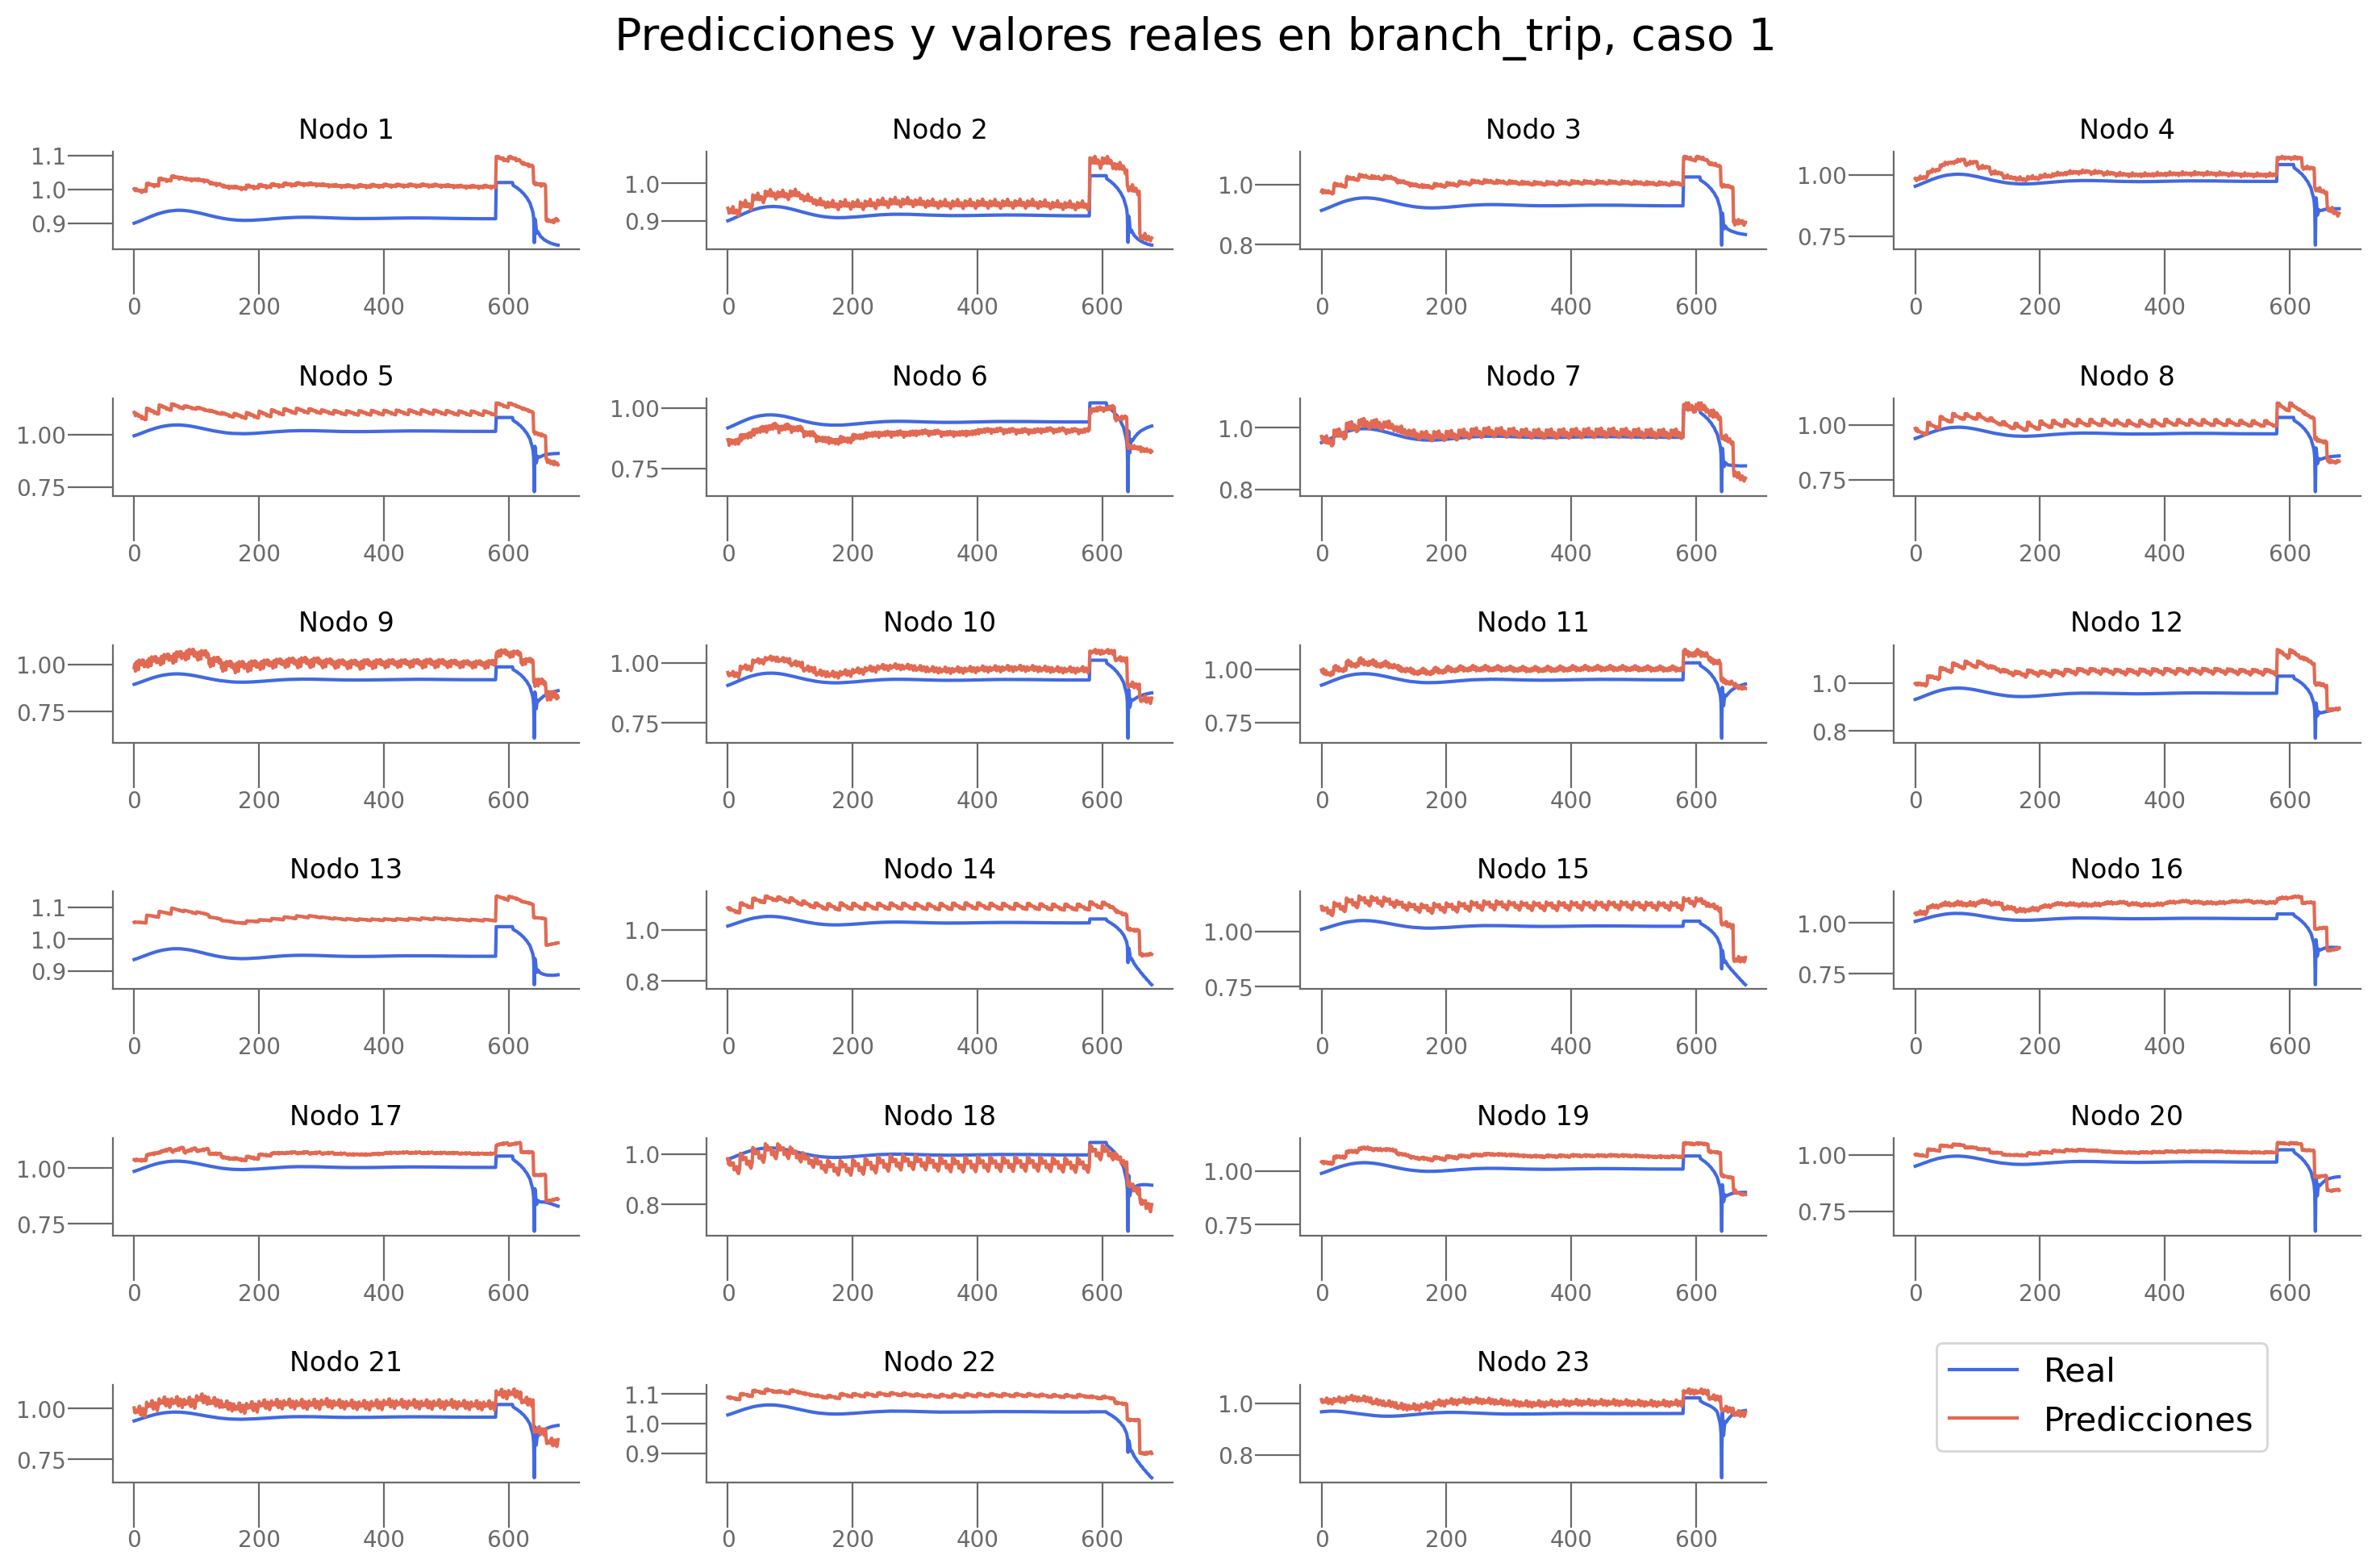

In [ ]:
_,_,_, predictions_brt_ajuste,real_brt_ajuste = trainer_brt.test()
plot_predictions(predictions_brt_ajuste, real_brt_ajuste, n_target, 1, n_div_brt, problem_brt)

In [ ]:
trainer_brt.save_model(path_save_experiment=path_save_experiment_brt, params = params_brt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                 Params  \
0          LSTM                                    NaN   
1  LSTM_NOBATCH                                    NaN   
2   DyGrEncoder  {'aggr': 'add', 'conv': 1, 'lstm': 2}   
3     MPNN_LSTM    {'hidden_size': 32, 'dropout': 0.8}   
4         AGCRN                  {'hidden': 5, 'K': 2}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.003700  0.398922   
1                                                NaN  0.004787 -1.839737   
2  ./results/branch_trip/ajustes/DryGrEncoder_res...  0.002719 -0.549398   
3  ./results/branch_trip/ajustes/MPNNLSTM_results...  0.004205 -1.453302   
4    ./results/branch_trip/ajustes/AGCRN_results.csv  0.005193 -0.096764   

                                          Loss_nodes   R2_eval  Loss_eval  \
0  [0.0036937  0.00202668 0.00244704 0.00374463 0... 